## PHẦN 1: CÀI ĐẶT, IMPORTS & THIẾT LẬP BAN ĐẦU

In [20]:
# ==============================================================================
# CELL 1.1: CÀI ĐẶT THƯ VIỆN & BIẾN MÔI TRƯỜNG (CẬP NHẬT)
# ==============================================================================
import os
import json
import asyncio
import operator
import time 
import re
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union

# Tải các biến môi trường
from dotenv import load_dotenv 
load_dotenv()

# LangChain & LangGraph
from langchain_core.messages import BaseMessage, HumanMessage   
from pydantic.v1 import BaseModel, Field, schema_json_of
# --- NÂNG CẤP: Chuyển sang thư viện Google Generative AI (dành cho AI Studio) ---
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

# --- NÂNG CẤP: Thêm công cụ tìm kiếm ---
from langchain_community.tools.tavily_search import TavilySearchResults

# Thư viện hỗ trợ & Kho tri thức
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from rich.console import Console
from rich.markdown import Markdown
from rich.pretty import pprint
from IPython.display import Image, display

In [21]:
# ==============================================================================
# CELL 1.2: CẤU HÌNH LOG & CÁC HÀM IN ẤN
# ==============================================================================
from langchain_groq import ChatGroq
# --- CẤU HÌNH LOG ---
VERBOSE_MODE = True

# --- KHỞI TẠO CÁC CÔNG CỤ IN ẤN ---
console = Console()

def print_step(message: str):
    if VERBOSE_MODE:
        console.print(f"\n[bold cyan]>[/bold cyan] {message}")

def print_result(data: Any, title: str = "Kết quả"):
    if VERBOSE_MODE:
        console.print(f"[bold green]✔️ {title}:[/bold green]")
        pprint(data, expand_all=True)
        
def print_warning(message: str):
    if VERBOSE_MODE:
        console.print(f"[bold yellow]⚠️  {message}[/bold yellow]")

In [22]:
# ==============================================================================
# CELL 1.3: KHỞI TẠO LLM (NÂNG CẤP SANG GOOGLE AI STUDIO)
# ==============================================================================
try:
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash", # Sử dụng model mới nhất và mạnh nhất
        temperature=0.1,
        google_api_key=os.getenv("GOOGLE_API_KEY")
    )
    print("✅ LLM (Gemini 2.5 Flash từ Google AI Studio) đã được khởi tạo thành công.")
except Exception as e:
    print(f"❌ LỖI: Không thể khởi tạo LLM. Hãy chắc chắn bạn đã cài 'langchain-google-genai' và có GOOGLE_API_KEY trong file .env. Lỗi: {e}")
    llm = None

✅ LLM (Gemini 2.5 Flash từ Google AI Studio) đã được khởi tạo thành công.


In [23]:
# ==============================================================================
# CELL 1.5: KHỞI TẠO VÀ QUẢN LÝ TRÍ NHỚ DÀI HẠN (NÂNG CẤP V9.4)
# ==============================================================================
MEMORY_FILE_PATH = "long_term_memory.json"
memory_vector_store = None

# Hàm để tải trí nhớ từ file JSON
def load_memory():
    if not os.path.exists(MEMORY_FILE_PATH):
        return []
    with open(MEMORY_FILE_PATH, 'r', encoding='utf-8') as f:
        return json.load(f)

# Hàm để lưu một giáo án mới vào trí nhớ
def save_to_memory(request: str, structured_plan: Dict[str, Any]):
    memory = load_memory()
    memory.append({
        "request": request,
        "plan": structured_plan
    })
    with open(MEMORY_FILE_PATH, 'w', encoding='utf-8') as f:
        json.dump(memory, f, ensure_ascii=False, indent=2)
    print_step("🧠 Đã lưu giáo án thành công vào Trí nhớ Dài hạn.")

# Hàm để tạo một vector store từ trí nhớ (để tìm kiếm tương đồng)
def build_memory_vector_store():
    global memory_vector_store
    memory_content = load_memory()
    if not memory_content:
        print_warning("Trí nhớ trống, không có gì để xây dựng vector store.")
        return

    # Chỉ lấy phần 'request' để tìm kiếm
    texts = [item['request'] for item in memory_content]
    # Lưu toàn bộ item làm metadata
    metadatas = memory_content
    
    memory_vector_store = FAISS.from_texts(texts, embeddings, metadatas=metadatas)
    print_step("✅ Đã xây dựng Vector Store cho Trí nhớ Dài hạn.")

# Tự động xây dựng vector store khi khởi động notebook
build_memory_vector_store()

⚠️  Trí nhớ trống, không có gì để xây dựng vector store.

## PHẦN 2: ĐỊNH NGHĨA STATE CỦA HỆ THỐNG


In [24]:
# ==============================================================================
# CELL 1.4: TẢI KHO TRI THỨC (RAG)
# ==============================================================================
# --- TẢI KHO TRI THỨC ---
BASE_VECTOR_STORE_PATH = "vector_store"
vector_store = None
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

if os.path.exists(BASE_VECTOR_STORE_PATH):
    subdirectories = [f.path for f in os.scandir(BASE_VECTOR_STORE_PATH) if f.is_dir()]
    if not subdirectories:
        print(f"❌ LỖI: Không tìm thấy thư mục con nào trong '{BASE_VECTOR_STORE_PATH}'.")
    else:
        try:
            print_step(f"Đang tải và hợp nhất các kho tri thức từ {len(subdirectories)} thư mục...")
            # Tải kho tri thức đầu tiên để làm cơ sở
            first_store_path = subdirectories.pop(0)
            vector_store = FAISS.load_local(first_store_path, embeddings, allow_dangerous_deserialization=True)
            print(f"✅ Đã tải thành công kho tri thức cơ sở: '{os.path.basename(first_store_path)}'")

            # Hợp nhất các kho tri thức còn lại
            for store_path in subdirectories:
                if os.path.exists(os.path.join(store_path, "index.faiss")):
                    temp_store = FAISS.load_local(store_path, embeddings, allow_dangerous_deserialization=True)
                    vector_store.merge_from(temp_store)
                    print(f"✅ Đã hợp nhất thành công: '{os.path.basename(store_path)}'")
                else:
                    print_warning(f"Bỏ qua thư mục '{os.path.basename(store_path)}' vì không chứa file index.faiss.")
            
            print("\n[bold green]✔️ Tất cả các kho tri thức RAG đã được tải và hợp nhất thành công.[/bold green]")

        except Exception as e:
            print(f"❌ LỖI trong quá trình tải hoặc hợp nhất kho tri thức: {e}")
else:
    print(f"❌ LỖI: Không tìm thấy thư mục gốc của kho tri thức tại '{BASE_VECTOR_STORE_PATH}'.")


> Đang tải và hợp nhất các kho tri thức từ 2 thư mục...

✅ Đã tải thành công kho tri thức cơ sở: 'sgk_toan_12_1'
✅ Đã hợp nhất thành công: 'sgk_toan_9'

[bold green]✔️ Tất cả các kho tri thức RAG đã được tải và hợp nhất thành công.[/bold green]


In [25]:
# ==============================================================================
# CELL 2.1: ĐỊNH NGHĨA STATE NÂNG CAO (v9.0)
# ==============================================================================
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
import operator

# --- Hàm tiện ích (giữ nguyên) ---
def merge_dicts(dict1: Dict[str, Any], dict2: Dict[str, Any]) -> Dict[str, Any]:
    merged = dict1.copy()
    for key, value in dict2.items():
        if key in merged and isinstance(merged[key], dict) and isinstance(value, dict):
            merged[key] = merge_dicts(merged[key], value)
        else:
            merged[key] = value
    return merged

# --- Cấu trúc dữ liệu con (giữ nguyên) ---
class DetailedTask(TypedDict):
    task_id: int
    task_name: str
    task_description: str
    estimated_duration: int 
    status: Literal["pending", "completed"]

# === NÂNG CẤP V9.0: CÁC CẤU TRÚC DỮ LIỆU MỚI CHO TƯ DUY SÂU ===
class DifferentiatedInstruction(TypedDict):
    """Gợi ý cho việc dạy học phân hóa trong một hoạt động."""
    for_struggling_students: str
    for_advanced_students: str

class StructuredContentItem(TypedDict):
    """Định nghĩa một hoạt động hoặc đánh giá có cấu trúc."""
    task_id: int
    activity_name: str
    question_or_description: str # Gộp 'question' và 'description'
    duration_minutes: int
    content_type: str # Gộp 'activity_type' và 'question_type'
    teacher_actions: List[str]
    solution_guide: Any
    answer: Optional[str] # Dành cho câu hỏi đánh giá
    differentiation: Optional[DifferentiatedInstruction]

class FinalStructuredPlan(TypedDict):
    """Định nghĩa cấu trúc JSON cho giáo án cuối cùng."""
    general_info: Dict[str, Any]
    learning_objectives: List[str]
    preparation: Dict[str, List[str]]
    knowledge_summary: str
    lesson_flow: List[StructuredContentItem]
    # pedagogical_explainer: Dict[str, Any] # Dành cho nâng cấp tương lai

# === NÂNG CẤP V9.0: STATE MỚI VỚI CÁC TRƯỜNG TRÍ TUỆ MỚI ===
class TeacherStateV5(TypedDict):
    # Các trường cơ bản
    original_request: str
    messages: Annotated[List[BaseMessage], add_messages]
    domain: Optional[str]
    
    # === NÂNG CẤP: student_persona giờ sẽ chứa cả chiến lược phân hóa ===
    student_persona: Optional[Dict[str, Any]] 
    
    # Các bước tuần tự ban đầu
    analyzed_objective: Optional[Any]
    pedagogy_strategy: Optional[Any]
    pedagogical_blueprint: Optional[List[str]]

    # Các trường nâng cao
    expanded_queries: Optional[List[str]]
    task_list: Optional[List[DetailedTask]]
    current_task_id: Optional[int]
    reflection_notes: Optional[str]
    agent_outputs: Annotated[Dict[str, Any], merge_dicts] 
    next_agent: str
    
    # Các trường tạm thời cho vòng lặp kiểm duyệt vi mô (Micro-loop)
    current_content_to_validate: Optional[Dict[str, Any]]
    validation_feedback: Optional[str]

    inspirational_example: Optional[List[Dict[str, Any]]]

    # === NÂNG CẤP: Output cuối cùng sẽ có 2 dạng ===
    final_structured_plan: Optional[FinalStructuredPlan] # Dạng JSON có cấu trúc
    final_markdown_plan: Optional[str] # Dạng Markdown để hiển thị

print("✅ 'TeacherStateV5' (v9.0 - Hỗ trợ Phân hóa & Cấu trúc) đã được định nghĩa.")

✅ 'TeacherStateV5' (v9.0 - Hỗ trợ Phân hóa & Cấu trúc) đã được định nghĩa.


In [26]:
# ==============================================================================
# CELL 2.2: NODE KHỞI TẠO STATE
# ==============================================================================
def initialize_state_node(state: TeacherStateV5) -> Dict[str, Any]:
    """
    Node đầu tiên trong graph.
    Lấy yêu cầu gốc từ tin nhắn đầu vào và điền vào trường 'original_request'.
    """
    print_step("`Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...")
    user_request = state['messages'][-1].content
    return {"original_request": user_request}

print("✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.")

✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.


## PHẦN 3: ĐỊNH NGHĨA CÁC AGENT

In [27]:
# ==============================================================================
# CELL 3.1: HÀM TIỆN ÍCH & CẤU TRÚC DỮ LIỆU (v9.7 - TƯ DUY LINH HOẠT)
# ==============================================================================
import json
from pydantic.v1 import BaseModel, Field, schema_json_of
from typing import List, Dict, Any, Literal, Optional

# --- Các hàm tiện ích giữ nguyên ---
def format_solution_guide(guide: Any) -> str:
    if not guide: return "Chưa có hướng dẫn."
    if isinstance(guide, str): return guide
    if isinstance(guide, list): return "\n".join(f"- {step}" for step in guide)
    if isinstance(guide, dict): return "\n".join(f"- {key.replace('_', ' ').title()}: {value}" for key, value in guide.items())
    return str(guide)

def format_teacher_actions(actions: Optional[List[str]]) -> str:
    if not actions: return "Giáo viên quan sát và hỗ trợ chung."
    return "\n".join(f"  - {action}" for action in actions)

def update_agent_outputs(state: "TeacherStateV5", key: str, value: Any) -> Dict[str, Any]:
    outputs = state.get("agent_outputs", {}).copy()
    if key not in outputs: outputs[key] = []
    outputs[key].append(value)
    return {"agent_outputs": outputs}

SYSTEM_PERSONA_PROMPT = "BẠN LÀ MỘT TRỢ LÝ AI CHUYÊN NGHIỆP, ĐÓNG VAI TRÒ MỘT GIÁO VIÊN GIÀU KINH NGHIỆM TẠI VIỆT NAM. LUÔN LUÔN trả lời bằng TIẾNG VIỆT."

# === CẬP NHẬT CẤU TRÚC HOẠT ĐỘNG LINH HOẠT ===
class DifferentiatedInstructionModel(BaseModel):
    for_struggling_students: str = Field(description="Gợi ý cụ thể cho nhóm học sinh yếu/gặp khó khăn.")
    for_advanced_students: str = Field(description="Gợi ý, thử thách hoặc hoạt động nâng cao cho nhóm học sinh giỏi.")

class LearningActivity(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động học tập.")
    activity_type: str = Field(description="Phân loại hoạt động. Ví dụ: 'Thảo luận nhóm', 'Thực hành cá nhân'")
    duration_minutes: int = Field(description="Tổng thời gian ước tính (bằng SỐ PHÚT) cho cả hai phần.")
    teacher_actions: List[str] = Field(description="Danh sách các hành động CỤ THỂ của GIÁO VIÊN.")
    # Thay 'description' bằng cấu trúc Lõi/Mở rộng
    core_component: str = Field(description="Mô tả phần hoạt động CỐT LÕI mà TẤT CẢ học sinh cần hoàn thành.")
    extension_component: Optional[str] = Field(description="Mô tả phần hoạt động MỞ RỘNG dành cho học sinh làm nhanh hoặc nếu còn dư thời gian.")
    solution_guide: Optional[Any] = Field(description="Hướng dẫn giải hoặc các câu hỏi gợi mở.")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="Gợi ý phân hóa cụ thể cho hoạt động này.")

class AssessmentItem(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động đánh giá.")
    question_type: str = Field(description="Loại câu hỏi. Ví dụ: 'Tự luận', 'Trắc nghiệm'")
    duration_minutes: int = Field(description="Tổng thời gian ước tính (bằng SỐ PHÚT) cho cả hai phần.")
    teacher_actions: List[str] = Field(description="Danh sách các hành động CỤ THỂ của GIÁO VIÊN.")
    # Thay 'question' bằng cấu trúc Lõi/Mở rộng
    core_component: str = Field(description="Nội dung câu hỏi hoặc đề bài CỐT LÕI mà TẤT CẢ học sinh cần hoàn thành.")
    extension_component: Optional[str] = Field(description="Câu hỏi phụ hoặc thử thách MỞ RỘNG dành cho học sinh làm nhanh hoặc nếu còn dư thời gian.")
    answer: str = Field(description="Đáp án chính xác và ngắn gọn cho phần CỐT LÕI.")
    solution_guide: Any = Field(description="Hướng dẫn giải chi tiết từng bước.")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="Gợi ý phân hóa cụ thể cho hoạt động này.")

# --- Các model khác giữ nguyên ---
class StudentPersona(BaseModel):
    learning_pace: Literal["nhanh", "trung bình", "chậm"] = Field(description="Tốc độ học tập chung của lớp.")
    engagement_style: Literal["chủ động", "thụ động", "hỗn hợp"] = Field(description="Mức độ tham gia chung của lớp.")
    special_notes: str = Field(description="Tóm tắt các đặc điểm nổi bật của lớp học.")

class StudentPersonaAndDifferentiation(StudentPersona):
    differentiation_strategy: DifferentiatedInstructionModel = Field(description="Chiến lược dạy học phân hóa tổng thể cho cả bài học dựa trên các đặc điểm của lớp.")

class DetailedTaskModel(BaseModel):
    task_name: str = Field(description="Tên của nhiệm vụ này.")
    task_description: str = Field(description="Mô tả chi tiết nhiệm vụ cần thực hiện.")
    estimated_duration: int = Field(description="Thời gian ước tính (bằng phút) cho nhiệm vụ này.")

class TaskListWithDuration(BaseModel):
    tasks: List[DetailedTaskModel]

class DetailedPedagogyChoice(BaseModel):
    name: str = Field(description="Tên của phương pháp sư phạm được chọn.")
    rationale: str = Field(description="Lý do tại sao phương pháp này phù hợp.")
    key_actions: List[str] = Field(description="Danh sách các hành động/hoạt động cốt lõi đặc trưng cho phương pháp này.")

class ValidationResult(BaseModel):
    is_valid: bool = Field(description="Nội dung có hợp lệ và chính xác về mặt chuyên môn không.")
    feedback: str = Field(description="Phản hồi chi tiết. Nếu không hợp lệ, hãy giải thích rõ ràng lỗi sai và gợi ý cách sửa.")
    suggested_duration: Optional[int] = Field(default=None, description="Nếu có lỗi về thời gian, hãy đề xuất một thời lượng hợp lý hơn (tính bằng SỐ PHÚT).")

class Domain(BaseModel): domain: str = Field(description="Lĩnh vực học thuật chính của yêu cầu.")
class ExpandedQueries(BaseModel): queries: List[str]
class BestSnippets(BaseModel): best_snippets: List[str]
class ParsedObjective(BaseModel): action_verb: str; bloom_level: int; topic: str; grade_level: str; duration_minutes: Optional[int]
class TaskClassification(BaseModel): agent_category: Literal["activity_designer", "theory_synthesizer", "assessment_creator"]
class BlueprintStage(BaseModel): stage_name: str; stage_objective: str; stage_direction: str
class PedagogicalBlueprint(BaseModel): blueprint: List[BlueprintStage]

print("✅ Các cấu trúc dữ liệu Pydantic (v9.7 - Hoạt động Linh hoạt) đã được định nghĩa.")

✅ Các cấu trúc dữ liệu Pydantic (v9.7 - Hoạt động Linh hoạt) đã được định nghĩa.


In [28]:
# ==============================================================================
# CELL 3.2: AGENT PHÂN TÍCH YÊU CẦU BAN ĐẦU (NÂNG CẤP V9.0)
# ==============================================================================
async def objective_interpreter_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Objective Interpreter` (v7.5) đang phân tích mục tiêu...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu của người dùng và trích xuất các thông tin sau.\n**YÊU CẦU:** \"{state['original_request']}\"\n**CÁC TRƯỜNG CẦN TRÍCH XUẤT:** `action_verb`, `bloom_level` (SỐ NGUYÊN), `topic`, `grade_level`, `duration_minutes`.\n**CHỈ TRẢ VỀ JSON.**"
    structured_llm = llm.with_structured_output(ParsedObjective, method="json_mode")
    try:
        parsed_result = await structured_llm.ainvoke(prompt)
        analyzed_objective_dict = parsed_result.dict()
        analyzed_objective_dict['constraints'] = {'duration_minutes': parsed_result.duration_minutes}
        del analyzed_objective_dict['duration_minutes']
        print_result(analyzed_objective_dict, "Mục tiêu & Ràng buộc đã phân tích")
        return {"analyzed_objective": analyzed_objective_dict}
    except Exception as e:
        print_warning(f"Lỗi tại Objective Interpreter: {e}. Sử dụng mục tiêu mặc định.")
        return {"analyzed_objective": { "action_verb": "soạn", "bloom_level": 3, "topic": state['original_request'], "grade_level": "9", "constraints": {"duration_minutes": 90} }}

async def domain_classifier_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Domain Classifier` (v7.5) đang xác định lĩnh vực chuyên môn...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu của người dùng và xác định lĩnh vực học thuật chính.\n**YÊU CẦU:** \"{state['original_request']}\"\n**LĨNH VỰC CÓ THỂ CHỌN:** 'Toán học', 'Vật lý', 'Hóa học', 'Sinh học', 'Văn học', 'Lịch sử', 'Địa lý', 'Ngoại ngữ', 'Tin học'.\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `domain`."
    structured_llm = llm.with_structured_output(Domain, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.domain, "Lĩnh vực chuyên môn được xác định")
        return {"domain": result.domain}
    except Exception as e:
        print_warning(f"Lỗi tại Domain Classifier: {e}. Sử dụng lĩnh vực mặc định 'Toán học'.")
        return {"domain": "Toán học"}

# === NÂNG CẤP: Agent này giờ đây là một nhà tư vấn chiến lược ===
# === SỬA LỖI PARSING: Prompt được làm rõ ràng hơn về cấu trúc lồng nhau ===
async def differentiated_instruction_advisor_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Differentiated Instruction Advisor` (v9.1) đang phân tích và đề xuất chiến lược phân hóa...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một chuyên gia sư phạm, chuyên về dạy học phân hóa.
    **NHIỆM VỤ:** Phân tích mô tả về lớp học dưới đây và đề xuất một chiến lược dạy học phân hóa TỔNG THỂ cho cả buổi học.
    **YÊU CẦU CỦA GIÁO VIÊN:** "{state['original_request']}"
    
    **CÁC BƯỚC SUY LUẬN (BẮT BUỘC):**
    1.  **Phân tích Đặc điểm:** Dựa vào các từ khóa, hãy xác định `learning_pace`, `engagement_style`, và tóm tắt vào `special_notes`.
    2.  **Đề xuất Chiến lược Phân hóa:** Dựa trên phân tích trên, hãy điền vào đối tượng `differentiation_strategy`. Đây PHẢI là một đối tượng JSON có 2 trường sau:
        -   `for_struggling_students`: Một chiến lược cụ thể để **hỗ trợ** nhóm học sinh có thể gặp khó khăn. (Ví dụ: "Chia nhỏ nhiệm vụ, cung cấp phiếu bài tập có gợi ý công thức, cho phép thêm thời gian.")
        -   `for_advanced_students`: Một chiến lược cụ thể để **thử thách** nhóm học sinh khá giỏi. (Ví dụ: "Chuẩn bị các câu hỏi mở rộng 'Tại sao?' và 'Nếu... thì sao?', giao một bài toán ứng dụng thực tế nhỏ.")

    **YÊU CẦU ĐỊNH DẠNG:** BẮT BUỘC trả về một đối tượng JSON duy nhất tuân thủ schema `StudentPersonaAndDifferentiation`. Trường `differentiation_strategy` PHẢI là một object lồng vào bên trong.
    """
    structured_llm = llm.with_structured_output(StudentPersonaAndDifferentiation, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Hồ sơ lớp học và Chiến lược Phân hóa")
        return {"student_persona": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Differentiated Instruction Advisor: {e}. Sử dụng hồ sơ mặc định.")
        fallback_persona = {
            "learning_pace": "trung bình",
            "engagement_style": "hỗn hợp",
            "special_notes": "Không có ghi chú đặc biệt.",
            "differentiation_strategy": {
                "for_struggling_students": "Quan sát và hỗ trợ thêm khi cần thiết.",
                "for_advanced_students": "Khuyến khích các em tìm tòi thêm."
            }
        }
        return {"student_persona": fallback_persona}

print("✅ Các agent phân tích yêu cầu ban đầu (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.")

✅ Các agent phân tích yêu cầu ban đầu (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.


In [29]:
# ==============================================================================
# CELL 3.3: AGENT LẬP KẾ HOẠCH CHIẾN LƯỢC (v7.5)
# ==============================================================================
async def pedagogy_strategist_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogy Strategist` (v7.5) đang xây dựng chiến lược sư phạm chi tiết...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **MỤC TIÊU BÀI HỌC:** {state.get('analyzed_objective')}
    **HỒ SƠ LỚP HỌC:** {state.get('student_persona')}
    **NHIỆM VỤ:** Dựa vào mục tiêu và hồ sơ lớp học, hãy chọn MỘT phương pháp sư phạm phù hợp nhất. Sau đó, phân tích phương pháp đó thành các hành động cốt lõi.
    **VÍ DỤ:** Nếu chọn 'Dạy học theo dự án', key_actions có thể là ["Giao dự án", "Học sinh làm việc nhóm", "Báo cáo sản phẩm"].
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với các key `name`, `rationale`, `key_actions`.
    """
    structured_llm = llm.with_structured_output(DetailedPedagogyChoice, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Chiến lược sư phạm chi tiết")
        return {"pedagogy_strategy": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogy Strategist: {e}. Sử dụng chiến lược mặc định.")
        return {"pedagogy_strategy": {"name": "Dạy học giải quyết vấn đề", "rationale": "Mặc định do lỗi.", "key_actions": ["Nêu vấn đề", "Học sinh tìm giải pháp", "Trình bày kết quả"]}}

async def pedagogical_architect_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogical Architect` (v9.4) đang thiết kế kịch bản buổi học...")
    
    inspirational_example = state.get("inspirational_example")
    example_prompt_part = ""
    if inspirational_example:
        example_prompt_part = f"""
        **VÍ DỤ THAM KHẢO (TỪ MỘT GIÁO ÁN THÀNH CÔNG TRƯỚC ĐÂY):**
        Đây là một luồng hoạt động đã được chứng minh là hiệu quả cho một chủ đề tương tự. Hãy học hỏi cấu trúc và cách tiếp cận từ nó:
        ```json
        {json.dumps(inspirational_example, ensure_ascii=False, indent=2)}
        ```
        """
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT} Với vai trò là một chuyên gia thiết kế trải nghiệm học tập.
    **NHIỆM VỤ:** Xây dựng một "Bản thiết kế Sư phạm" - một kịch bản CẤP CAO cho buổi học.
    
    {example_prompt_part}
    **QUY TẮC:**
    1.  Tạo ra 3-5 giai đoạn chính cho dòng chảy của buổi học.
    2.  Mỗi giai đoạn phải có tên (`stage_name`), mục tiêu (`stage_objective`), và định hướng (`stage_direction`).
    3.  Đảm bảo độ khó tăng tiến qua các giai đoạn.
    **THÔNG TIN PHÂN TÍCH:**
    - Mục tiêu: {state.get('analyzed_objective')}
    - Hồ sơ lớp học: {state.get('student_persona')}
    - Chiến lược Sư phạm: {state.get('pedagogy_strategy')}
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key là `blueprint`, giá trị là một danh sách các đối tượng Stage.
    """
    structured_llm = llm.with_structured_output(PedagogicalBlueprint, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        blueprint_list_of_strings = [f"{stage.stage_name}: {stage.stage_direction}" for stage in result.blueprint]
        print_result(blueprint_list_of_strings, "Bản thiết kế Sư phạm đã được tạo")
        return {"pedagogical_blueprint": blueprint_list_of_strings}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogical Architect: {e}. Sử dụng blueprint mặc định.")
        return {"pedagogical_blueprint": ["Giai đoạn 1: Giới thiệu bài học", "Giai đoạn 2: Luyện tập", "Giai đoạn 3: Đánh giá"]}

async def memory_retrieval_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Memory Retrieval` (v9.4) đang tìm kiếm trong trí nhớ...")
    
    if not memory_vector_store:
        print_warning("Không có Trí nhớ Dài hạn. Bỏ qua bước này.")
        return {"inspirational_example": None}

    user_request = state["original_request"]
    
    # Tìm kiếm 1 ví dụ tương đồng nhất trong trí nhớ
    try:
        results = memory_vector_store.similarity_search_with_score(user_request, k=1)
        if results and results[0][1] < 0.5: # Chỉ lấy nếu độ tương đồng cao (điểm score thấp là tốt)
            best_example = results[0][0].metadata
            print_result(best_example['request'], "Tìm thấy ví dụ tương đồng trong trí nhớ")
            # Chỉ trả về phần "lesson_flow" để làm ví dụ
            return {"inspirational_example": best_example['plan']['lesson_flow']}
        else:
            print_step("Không tìm thấy ví dụ nào đủ tương đồng trong trí nhớ.")
            return {"inspirational_example": None}
    except Exception as e:
        print_warning(f"Lỗi khi truy xuất trí nhớ: {e}")
        return {"inspirational_example": None}
    
print("✅ Các agent lập kế hoạch chiến lược đã sẵn sàng.")

✅ Các agent lập kế hoạch chiến lược đã sẵn sàng.


In [30]:
# ==============================================================================
# CELL 3.4: AGENT TRUY XUẤT VÀ TỔNG HỢP KIẾN THỨC (RAG) (v7.5)
# ==============================================================================
async def query_expansion_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Query Expansion` (v7.5) đang phân tích yêu cầu...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Tạo ra các cụm từ tìm kiếm đa dạng bằng tiếng Việt để tìm tài liệu.\n**CHỦ ĐỀ:** \"{state.get('analyzed_objective', {}).get('topic', '')}\"\n**LĨNH VỰC:** {state.get('domain', 'Chung')}\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `queries`."
    structured_llm = llm.with_structured_output(ExpandedQueries, method="json_mode")
    try:
        response = await structured_llm.ainvoke(prompt)
        print_result(response.queries, "Các truy vấn tìm kiếm đã được mở rộng")
        return {"expanded_queries": response.queries}
    except Exception as e:
        print_warning(f"Lỗi tại Query Expansion: {e}. Sử dụng truy vấn gốc.")
        return {"expanded_queries": [state.get('analyzed_objective', {}).get('topic', '')]}

async def resource_scout_agent_v2(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Resource Scout` (v8.1 - Sửa lỗi) đang tìm kiếm và sàng lọc...")
    retriever = vector_store.as_retriever(search_kwargs={"k": 5})
    all_docs = []
    queries = state.get('expanded_queries', [state.get('analyzed_objective', {}).get('topic', '')])
    for query in queries:
        all_docs.extend(retriever.invoke(query))
    unique_docs_content = list({doc.page_content for doc in all_docs})[:8]
    print_step(f"Tìm thấy {len(all_docs)} tài liệu, sàng lọc còn {len(unique_docs_content)} đoạn văn bản độc nhất.")
    
    # --- Phần Re-ranker giữ nguyên ---
    rerank_prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu gốc và chọn ra 3-4 đoạn văn bản tiếng Việt phù hợp NHẤT từ danh sách dưới đây.\n**YÊU CẦU GỐC:** \"{state.get('original_request', '')}\"\n**DANH SÁCH TÀI LIỆU:** {json.dumps(unique_docs_content, ensure_ascii=False)}\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `best_snippets`."
    structured_llm_reranker = llm.with_structured_output(BestSnippets, method="json_mode")
    best_snippets_text = "\n\n---\n\n".join(unique_docs_content)
    try:
        reranked_result = await structured_llm_reranker.ainvoke(rerank_prompt)
        best_snippets_text = "\n\n---\n\n".join(reranked_result.best_snippets)
    except Exception as e:
        print_warning(f"Lỗi tại Re-ranker: {e}. Sử dụng tất cả tài liệu.")

    # === ĐẠI TU PROMPT TÓM TẮT ===
    summary_prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một chuyên gia tổng hợp thông tin.
    **NHIỆM VỤ DUY NHẤT:** Dựa **CHỈ** vào các đoạn văn bản dưới đây, hãy viết một bản **TÓM TẮT KIẾN THỨC CỐT LÕI** về chủ đề "{state.get('analyzed_objective', {}).get('topic', '')}".

    **QUY TẮC TUYỆT ĐỐI:**
    1.  **CHỈ DÙNG THÔNG TIN ĐƯỢC CUNG CẤP:** Tuyệt đối không được bình luận về chất lượng của các đoạn văn bản. Không được "từ chối" tóm tắt.
    2.  **TỔNG HỢP & SUY LUẬN:** Nhiệm vụ của bạn là đọc tất cả các mẩu thông tin (kể cả từ các bài tập) và suy luận ra các định nghĩa, tính chất cốt lõi nhất.
    3.  **CẤU TRÚC RÕ RÀNG:** Trình bày bản tóm tắt một cách mạch lạc, có đầu mục rõ ràng (ví dụ: 1. Định nghĩa, 2. Tính chất...).
    4.  **TRẢ VỀ TÓM TẮT:** Luôn luôn trả về một bản tóm tắt, ngay cả khi nó ngắn gọn do thông tin hạn chế.

    **CÁC ĐOẠN VĂN BẢN ĐỂ TÓM TẮT:**
    {best_snippets_text}
    """
    summary = "Chưa có bản tóm tắt kiến thức."
    try:
        summary_response = await llm.ainvoke(summary_prompt)
        summary = summary_response.content
    except Exception as e:
        print_warning(f"Lỗi tại bước tóm tắt: {e}.")
        
    resource = {"source": "Sách giáo khoa (từ RAG - đã sàng lọc)", "summary": summary}
    print_result(resource, "Tài liệu RAG cuối cùng")
    return update_agent_outputs(state, "resources", resource)

print("✅ Các agent RAG đã sẵn sàng.")

✅ Các agent RAG đã sẵn sàng.


In [31]:
# ==============================================================================
# CELL 3.5: AGENT GIAO VIỆC & CHUYÊN MÔN (v10.0 - KỶ LUẬT THÉP)
# ==============================================================================

# === NÂNG CẤP LỚN: Plan Delegator với "Kinh nghiệm Sư phạm" ===
async def plan_delegator_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Plan Delegator` (v10.0 - Nhà hoạch định Thông thái) đang triển khai...")
    
    blueprint = state.get('pedagogical_blueprint', [])
    total_duration = state.get('analyzed_objective', {}).get('constraints', {}).get('duration_minutes', 90)

    # Bắt đầu lại với agent_outputs sạch sẽ mỗi khi lập kế hoạch lại
    agent_outputs_history = state.get("agent_outputs", {})
    new_agent_outputs = {"resources": agent_outputs_history.get("resources", [])}
        
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một Nhà Hoạch định Sư phạm giàu kinh nghiệm.
    **NHIỆM VỤ:** Chuyển đổi "Bản thiết kế Sư phạm" thành một danh sách các nhiệm vụ cụ thể, với sự phân bổ thời gian THỰC TẾ và KHẢ THI.

    **BẢN THIẾT KẾ SƯ PHẠM:**
    {json.dumps(blueprint, ensure_ascii=False, indent=2)}

    **BẢNG TRA CỨU KINH NGHIỆM SƯ PHẠM (THAM KHẢO BẮT BUỘC):**
    - Khởi động/Khám phá: ~10-15 phút.
    - Xây dựng kiến thức (mỗi khái niệm lớn): ~15-20 phút.
    - Thực hành/Hoạt động nhóm: ~20-30 phút.
    - Luyện tập/Củng cố: ~15-20 phút.
    - Tổng kết/Đánh giá/Giao bài tập: ~5-10 phút.

    **QUY TẮC TUYỆT ĐỐI:**
    1.  **PHÂN BỔ THỰC TẾ:** Dựa vào Bảng tra cứu kinh nghiệm, hãy phân bổ thời gian cho từng nhiệm vụ một cách hợp lý.
    2.  **TUÂN THỦ TỔNG THỜI GIAN:** Tổng thời lượng của tất cả các nhiệm vụ cộng lại PHẢI bằng chính xác **{total_duration} phút**.
    
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON tuân thủ schema `TaskListWithDuration`.
    """
    
    structured_llm = llm.with_structured_output(TaskListWithDuration, method="json_mode")
    
    try:
        task_list_result = await structured_llm.ainvoke(prompt)
        tasks_with_status = [{"task_id": i, **t.dict(), "status": "pending"} for i, t in enumerate(task_list_result.tasks) if t]
        
        print_result(tasks_with_status, f"Đã tạo {len(tasks_with_status)} nhiệm vụ chi tiết")
        
        return {"task_list": tasks_with_status, "reflection_notes": None, "agent_outputs": new_agent_outputs}
    
    except Exception as e:
        print_warning(f"Lỗi tại Plan Delegator: {e}. Tạo task mặc định.")
        fallback_task = { "task_id": 0, "task_name": "Hoạt động luyện tập", "task_description": "Học sinh thực hành bài tập.", "estimated_duration": 45, "status": "pending" }
        return {"task_list": [fallback_task], "reflection_notes": None, "agent_outputs": state.get("agent_outputs", {})}


# === NÂNG CẤP LỚN: Critic trở thành "Người bảo vệ Kế hoạch" ===
async def content_validator_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step(f"`Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...")
    content = state.get('current_content_to_validate')
    task_list = state.get('task_list', [])
    current_task = next((t for t in task_list if t['task_id'] == state.get('current_task_id')), None)
    
    if not content or content.get("error"):
        return {"validation_feedback": "Lỗi tạo nội dung, không thể phản biện."}

    estimated_duration = current_task.get('estimated_duration', 'N/A')

    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một Người Bảo vệ Kế hoạch, nhiệm vụ của bạn là đảm bảo các hoạt động được tạo ra phải TUÂN THỦ KẾ HOẠCH GỐC.
    **KẾ HOẠCH GỐC ĐÃ BAN HÀNH:**
    - Nhiệm vụ: "{current_task.get('task_name', 'N/A')}"
    - Thời gian cho phép: **{estimated_duration} phút.**

    **NỘI DUNG CẦN THẨM ĐỊNH:**
    ```json
    {json.dumps(content, ensure_ascii=False, indent=2)}
    ```
    **CÁC BƯỚC SUY LUẬN:**
    1.  **Kiểm tra Chất lượng:** Nội dung có chính xác chuyên môn và phù hợp sư phạm không? Nếu có lỗi, `is_valid: false`.
    2.  **Kiểm tra Tuân thủ Thời gian (QUAN TRỌNG NHẤT):** Dựa vào mô tả các bước trong nội dung, hãy ước tính xem hoạt động này có thực sự có thể hoàn thành trong **{estimated_duration} phút** hay không.
        - Nếu có thể hoàn thành, `is_valid: true`.
        - Nếu nội dung quá chi tiết, nhiều bước, và rõ ràng sẽ mất nhiều thời gian hơn so với kế hoạch, `is_valid: false`.

    **YÊU CẦU ĐỊNH DẠNG:**
    - Nếu hợp lệ và tuân thủ kế hoạch: `is_valid: true`, `feedback: "Nội dung hợp lệ."`.
    - Nếu không hợp lệ (lỗi chất lượng hoặc thời gian): `is_valid: false`, `feedback` phải giải thích rõ tại sao nội dung không tuân thủ kế hoạch và đưa ra mệnh lệnh: **"Hãy thiết kế lại một phiên bản hoạt động đơn giản hơn, ít bước hơn để khớp với thời gian {estimated_duration} phút đã cho."** TUYỆT ĐỐI KHÔNG đề xuất tăng thời gian (`suggested_duration` phải là null).
    """
    # Sử dụng ValidationResult nhưng sẽ bỏ qua suggested_duration
    structured_llm = llm.with_structured_output(ValidationResult, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        if result.is_valid:
            print_step("✔️ GUARDIAN: Nội dung tuân thủ kế hoạch!")
            return {"validation_feedback": None}
        else:
            # Loại bỏ suggested_duration nếu có
            clean_feedback = result.feedback.split("|")[0].strip()
            print_warning(f"GUARDIAN PHẢN BIỆN: {clean_feedback}")
            return {"validation_feedback": clean_feedback}
    except Exception as e:
        print_warning(f"Lỗi tại Guardian Critic: {e}. Mặc định cho qua.")
        return {"validation_feedback": None}

# === NÂNG CẤP LỚN: Specialist Agent với "Tư duy Kỷ luật" ===
async def specialist_agent_logic(state: "TeacherStateV5", agent_type: str, pydantic_model: type[BaseModel]) -> Dict[str, Any]:
    print_step(f"`Agent: {agent_type}` (v10.0) đang tạo nội dung theo kỷ luật...")
    task_to_run = next((t for t in state.get('task_list', []) if t['task_id'] == state.get('current_task_id')), None)
    if not task_to_run: return {"current_content_to_validate": {"error": "Không tìm thấy task hiện tại."}}

    feedback_prompt = ""
    if state.get('validation_feedback'):
        feedback_prompt = f"""
        **MỆNH LỆNH TỪ NGƯỜI BẢO VỆ (BẮT BUỘC SỬA):**
        "{state.get('validation_feedback', '')}"
        Điều này có nghĩa là phiên bản trước của bạn quá phức tạp. Hãy tạo một phiên bản **đơn giản hơn, ít bước hơn, hoặc ít câu hỏi hơn** để đảm bảo nó có thể hoàn thành trong thời gian cho phép.
        """
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một nhà thiết kế hoạt động học tập sáng tạo, tuân thủ nghiêm ngặt kế hoạch được giao.
    
    **KẾ HOẠCH ĐÃ BAN HÀNH:**
    - Tên nhiệm vụ: "{task_to_run.get('task_name', '')}"
    - **THỜI GIAN TỐI ĐA (MỆNH LỆNH TUYỆT ĐỐI):** {task_to_run.get('estimated_duration', 10)} phút.

    {feedback_prompt}
    
    **QUY TẮC SỐ 1 - KỶ LUẬT THỜI GIAN:**
    Nhiệm vụ của bạn là **co giãn nội dung cho vừa với thời gian, không phải co giãn thời gian cho vừa với nội dung**. Hãy thiết kế hoạt động tốt nhất có thể trong giới hạn thời gian đã cho. Nếu cần, hãy giảm bớt số lượng bài tập, rút ngắn các bước, hoặc đơn giản hóa yêu cầu. **TUYỆT ĐỐI KHÔNG** tạo ra một hoạt động mà bạn biết sẽ mất nhiều thời gian hơn quy định.
    
    **CÁC QUY TẮC KHÁC:**
    - **CẤU TRÚC LÕI/MỞ RỘNG:** Phân chia hoạt động thành phần cốt lõi (phải hoàn thành) và phần mở rộng (nếu còn thời gian).
    - **TUÂN THỦ SCHEMA:** Trả về JSON theo đúng cấu trúc.
    
    ```json
    {schema_json_of(pydantic_model, indent=2)}
    ```
    """
    structured_llm = llm.with_structured_output(pydantic_model, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        content_dict = result.dict()
        # Gán lại thời gian từ task list để đảm bảo nhất quán
        content_dict['duration_minutes'] = task_to_run.get('estimated_duration', 10)
        content_dict['question_or_description'] = f"**Phần Cốt lõi:**\n{content_dict.get('core_component', '')}\n\n**Phần Mở rộng (nếu còn thời gian):**\n{content_dict.get('extension_component', 'Không có')}"
        print_result(content_dict, f"Nội dung do {agent_type} tạo ra")
        return {"current_content_to_validate": content_dict, "validation_feedback": None}
    except Exception as e:
        print_warning(f"Lỗi tại {agent_type}: {e}.")
        return {"current_content_to_validate": {"error": str(e)}}

async def theory_synthesizer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Theory Synthesizer", LearningActivity)
async def activity_designer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Activity Designer", LearningActivity)
async def assessment_creator_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Assessment Creator", AssessmentItem)

print("✅ Các agent giao việc và chuyên môn (v10.0 - Kỷ luật Thép) đã sẵn sàng.")

✅ Các agent giao việc và chuyên môn (v10.0 - Kỷ luật Thép) đã sẵn sàng.


In [32]:
# ==============================================================================
# CELL 3.6: AGENT TỔNG HỢP & NODE TRÌNH BÀY (v10.0.1 - SỬA LỖI BIÊN DỊCH)
# ==============================================================================

async def structured_plan_compiler_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Structured Plan Compiler` (v10.0.1) đang tổng hợp giáo án...")
    outputs = state.get('agent_outputs', {})
    objective = state.get('analyzed_objective', {})
    
    activities = outputs.get('activities', [])
    assessments = outputs.get('assessments', [])
    all_content_items = activities + assessments
    allowed_duration = objective.get('constraints', {}).get('duration_minutes', 90)

    if not all_content_items:
        reflection = "Kế hoạch thất bại. Không có hoạt động nào được tạo ra. Lập kế hoạch lại."
        print_warning(f"CRITIC LỚN: {reflection}")
        return {"reflection_notes": reflection}

    total_duration = sum(item.get('duration_minutes', 0) for item in all_content_items)
    
    # <-- SỬA LỖI Ở ĐÂY: Chuyển dòng này lên trên, thực hiện sắp xếp trước khi phân nhánh
    all_content_sorted = sorted(all_content_items, key=lambda x: x.get('task_id', float('inf')))

    # Nếu tổng thời gian hợp lệ, cho qua ngay
    if (allowed_duration * 0.95) <= total_duration <= (allowed_duration + 5):
         print_step(f"CRITIC LỚN: Kế hoạch hợp lệ! Tổng thời gian ({total_duration} phút) nằm trong giới hạn cho phép.")
    # Nếu không, thử "cắt tỉa" hoạt động cuối
    else:
        print_warning(f"CRITIC LỚN: Tổng thời gian ({total_duration} phút) không hợp lệ. Đang thử cắt tỉa hoạt động cuối...")
        
        last_activity = all_content_sorted[-1]
        
        is_flexible = "vận dụng" in last_activity.get('activity_name', '').lower() or \
                      "luyện tập" in last_activity.get('activity_name', '').lower() or \
                      "tổng kết" in last_activity.get('activity_name', '').lower() or \
                      last_activity.get('extension_component')

        if is_flexible:
            duration_of_last_activity = last_activity.get('duration_minutes', 0)
            duration_of_other_activities = total_duration - duration_of_last_activity
            
            new_duration_for_last = allowed_duration - duration_of_other_activities
            
            if new_duration_for_last >= 5:
                print_step(f"Điều chỉnh thành công! Cắt bớt hoạt động cuối từ {duration_of_last_activity} phút xuống còn {new_duration_for_last} phút.")
                last_activity['duration_minutes'] = new_duration_for_last
                last_activity['question_or_description'] = f"**Phần Cốt lõi:**\n{last_activity.get('core_component', '')}\n\n**Phần Mở rộng:** (Phần này có thể được bỏ qua do hạn chế về thời gian)"
                # Cập nhật lại danh sách đã sắp xếp
                all_content_sorted = all_content_sorted[:-1] + [last_activity]
            else:
                reflection = f"Kế hoạch thất bại. Tổng thời gian ({total_duration} phút) quá dài, không thể cứu vãn. Lập kế hoạch lại từ đầu với thời gian ngắn hơn."
                print_warning(f"CRITIC LỚN: {reflection}")
                return {"reflection_notes": reflection}
        else:
            reflection = f"Kế hoạch thất bại. Tổng thời gian ({total_duration} phút) không hợp lệ và hoạt động cuối không phải hoạt động linh hoạt. Lập kế hoạch lại."
            print_warning(f"CRITIC LỚN: {reflection}")
            return {"reflection_notes": reflection}

    # --- Phần còn lại giữ nguyên ---
    print_step("Bắt đầu tổng hợp giáo án dạng JSON...")
    persona = state.get('student_persona', {})
    strategy = state.get('pedagogy_strategy', {})
    resources = state.get('agent_outputs', {}).get('resources', [{}])[0]

    general_info = { "chủ đề": objective.get('topic', 'N/A'), "môn học": state.get('domain', 'N/A'), "lớp": objective.get('grade_level', 'N/A'), "thời lượng": f"{allowed_duration} phút", "phương pháp chủ đạo": strategy.get('name', 'Chưa xác định'), "đặc điểm lớp học": persona.get('special_notes', 'Tiêu chuẩn'), }
    learning_objectives = [ f"Học sinh có thể {objective.get('action_verb', 'vận dụng')} kiến thức về {objective.get('topic', 'N/A')}.", "Rèn luyện kỹ năng tư duy logic và giải quyết vấn đề.", "Phát triển kỹ năng hợp tác và trình bày." ]
    preparation = { "giáo viên": ["Bảng phụ", "máy chiếu", "phiếu học tập"], "học sinh": ["Sách giáo khoa", "vở ghi", "dụng cụ học tập"] }
    final_plan_obj: FinalStructuredPlan = { "general_info": general_info, "learning_objectives": learning_objectives, "preparation": preparation, "knowledge_summary": resources.get('summary', 'Chưa có tóm tắt.'), "lesson_flow": all_content_sorted, } # Bây giờ biến này luôn tồn tại

    return {"final_structured_plan": final_plan_obj, "reflection_notes": None}


# --- markdown_presentation_node giữ nguyên ---
def markdown_presentation_node(state: "TeacherStateV5") -> Dict[str, str]:
    print_step("`Node: Markdown Presenter` (v10.0.1) đang tạo bản trình bày Markdown...")
    plan_json = state.get("final_structured_plan")
    if not isinstance(plan_json, dict): return {"final_markdown_plan": "Lỗi: Không tìm thấy giáo án."}

    md_parts = []
    info = plan_json.get('general_info', {})
    md_parts.append(f"# GIÁO ÁN BÀI DẠY: {info.get('chủ đề', 'N/A').upper()}")
    md_parts.append("---")
    md_parts.append("## I. THÔNG TIN CHUNG")
    for key, value in info.items(): md_parts.append(f"- **{key.replace('_', ' ').title()}:** {value}")
    md_parts.append("## II. MỤC TIÊU BÀI HỌC")
    for obj in plan_json.get('learning_objectives', []): md_parts.append(f"- {obj}")
    md_parts.append("## III. CHUẨN BỊ")
    for key, items in plan_json.get('preparation', {}).items(): md_parts.append(f"- **{key.title()}:** {', '.join(items)}")
    md_parts.append("## IV. TIẾN TRÌNH BÀI DẠY")
    for i, activity in enumerate(plan_json.get('lesson_flow', [])):
        md_parts.append(f"### Hoạt động {i+1}: {activity.get('activity_name')} ({activity.get('duration_minutes')} phút)")
        md_parts.append(f"**Nhiệm vụ:**\n{activity.get('question_or_description', 'Không có mô tả.')}")
        if activity.get('differentiation'):
            diff = activity['differentiation']
            md_parts.append(f"> **Gợi ý Phân hóa:**")
            md_parts.append(f"> - *Hỗ trợ (HS yếu):* {diff.get('for_struggling_students', 'Không có')}")
            md_parts.append(f"> - *Thử thách (HS giỏi):* {diff.get('for_advanced_students', 'Không có')}")
        md_parts.append("\n---")
    md_parts.append("## V. TÓM TẮT KIẾN THỨC CỐT LÕI")
    md_parts.append(plan_json.get('knowledge_summary', 'Chưa có tóm tắt.'))
    final_md = "\n".join(md_parts)
    return {"final_markdown_plan": final_md}

print("✅ Agent tổng hợp & Node trình bày (v10.0.1 - Sửa lỗi Biên dịch) đã sẵn sàng.")

✅ Agent tổng hợp & Node trình bày (v10.0.1 - Sửa lỗi Biên dịch) đã sẵn sàng.


## PHẦN 4: XÂY DỰNG VÀ BIÊN DỊCH GRAPH

In [33]:
# ==============================================================================
# CELL 4.1: CÁC NODE TIỆN ÍCH & ĐIỀU PHỐI (v10.0 - KỶ LUẬT THÉP)
# ==============================================================================
from typing import Literal, Dict, Any
import time

# --- CÁC NODE TIỆN ÍCH CƠ BẢN ---
def delay_node(state: "TeacherStateV5") -> "TeacherStateV5":
    time.sleep(1)
    return state

def mark_task_complete(state: "TeacherStateV5") -> Dict[str, Any]:
    task_list = state.get("task_list", [])
    current_task_id = state.get("current_task_id")
    if not task_list or current_task_id is None: return {}
    new_task_list = [t.copy() for t in task_list]
    for task in new_task_list:
        if task.get("task_id") == current_task_id:
            task["status"] = "completed"
            break
    return {"task_list": new_task_list, "current_task_id": None}
    
def task_router_node(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Router`: Đang kiểm tra nhiệm vụ...")
    task_list = state.get("task_list", [])
    next_task = next((task for task in task_list if task.get("status") == "pending"), None)
    if next_task:
        print_step(f"Nhiệm vụ tiếp theo: '{next_task['task_name']}' (ID: {next_task['task_id']})")
        return {"current_task_id": next_task['task_id']}
    else:
        print_step("Hết nhiệm vụ, chuyển sang node Compiler.")
        return {"current_task_id": None}

async def task_dispatcher_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Task Dispatcher` đang giao việc...")
    task_to_run = next((t for t in state['task_list'] if t['task_id'] == state['current_task_id']), None)
    if not task_to_run: return {"next_agent": "mark_task_complete"}

    task_description = task_to_run['task_description']
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**Nhiệm vụ:** Phân loại nhiệm vụ sau vào MỘT trong ba agent sau: 'activity_designer', 'theory_synthesizer', 'assessment_creator'.\n\n**QUY TẮC PHÂN LOẠI:**\n- Giảng giải, giới thiệu, ôn tập, tổng kết -> 'theory_synthesizer'.\n- Luyện tập, thực hành, thảo luận, làm việc nhóm -> 'activity_designer'.\n- Kiểm tra, đánh giá, bài toán khó, vận dụng cao -> 'assessment_creator'.\n\n**NHIỆM VỤ CẦN PHÂN LOẠI:** \"{task_description}\"\n\n**YÊU CẦU JSON:** Trả về JSON với key duy nhất là `agent_category`."
    structured_llm = llm.with_structured_output(TaskClassification)
    try:
        classification_result = await structured_llm.ainvoke(prompt)
        next_agent = classification_result.agent_category
    except Exception:
        next_agent = "activity_designer"
    print_step(f"--- 🚚 `Dispatcher`: Giao nhiệm vụ cho `{next_agent}`.")
    return {"next_agent": next_agent}

def commit_validated_content_node(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Commiter`: Đang ghi nhận nội dung đã được xác thực...")
    agent_ran = state["next_agent"]
    content = state["current_content_to_validate"]
    content['task_id'] = state['current_task_id']
    key_to_update = "assessments" if "answer" in content else "activities"
    updated_outputs = update_agent_outputs(state, key_to_update, content)
    updated_outputs["current_content_to_validate"] = None
    updated_outputs["validation_feedback"] = None
    return updated_outputs

def save_to_memory_node(state: "TeacherStateV5"):
    if state.get("final_structured_plan"):
        save_to_memory(state["original_request"], state["final_structured_plan"])
    return {} 

print("✅ Các node tiện ích và điều phối (v10.0 - Kỷ luật Thép) đã sẵn sàng.")

✅ Các node tiện ích và điều phối (v10.0 - Kỷ luật Thép) đã sẵn sàng.


In [34]:
# ==============================================================================
# CELL 4.2: LOGIC ĐIỀU HƯỚNG CÓ ĐIỀU KIỆN (ĐÃ SỬA LỖI)
# ==============================================================================
def route_after_validation(state: "TeacherStateV5") -> Literal["commit", "retry_content", "replan_task"]:
    """
    Hàm điều hướng mới, thông minh hơn sau khi thẩm định nội dung.
    - commit: Nội dung hợp lệ.
    - replan_task: Nội dung có lỗi cấu trúc/thời gian, cần quay lại bước lập kế hoạch.
    - retry_content: Nội dung có lỗi chuyên môn/sư phạm, cần agent chuyên môn thử lại.
    """
    feedback = state.get("validation_feedback")
    if feedback is None:
        print_step("ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.")
        return "commit"
    
    if "[STRUCTURAL_FEEDBACK]" in feedback:
        print_step("ROUTER (Validation): Lỗi cấu trúc, yêu cầu LẬP KẾ HOẠCH LẠI.")
        # Chuyển phản hồi này cho Plan Delegator
        state['reflection_notes'] = feedback
        return "replan_task"
    else:
        print_step("ROUTER (Validation): Nội dung bị từ chối. Quay lại để agent chuyên môn THỬ LẠI.")
        return "retry_content"

def route_after_router(state: "TeacherStateV5") -> Literal["continue_executing", "compile_and_critique"]:
    if state.get("current_task_id") is None: 
        return "compile_and_critique"
    else: 
        return "continue_executing"

def route_after_compilation(state: "TeacherStateV5") -> Literal["finish", "replan"]:
    if state.get("reflection_notes"):
        print_step("ROUTER (Compilation): Phát hiện phản hồi từ Critic lớn. Yêu cầu hệ thống lập kế hoạch lại.")
        return "replan"
    else:
        print_step("ROUTER (Compilation): Critic lớn đã hài lòng. Kết thúc quy trình.")
        return "finish"

print("✅ Các hàm logic điều hướng (đã sửa lỗi) đã được định nghĩa.")

✅ Các hàm logic điều hướng (đã sửa lỗi) đã được định nghĩa.


In [35]:
# ==============================================================================
# CELL 4.3: LẮP RÁP VÀ BIÊN DỊCH GRAPH (v10.0 - KỶ LUẬT THÉP)
# ==============================================================================
workflow = StateGraph(TeacherStateV5)

# 1. Thêm các node cần thiết
workflow.add_node("initializer", initialize_state_node)
workflow.add_node("memory_retrieval", memory_retrieval_agent)
workflow.add_node("objective_interpreter", objective_interpreter_agent)
workflow.add_node("domain_classifier", domain_classifier_agent)
workflow.add_node("differentiated_instruction_advisor", differentiated_instruction_advisor_agent) 
workflow.add_node("pedagogy_strategist", pedagogy_strategist_agent)
workflow.add_node("pedagogical_architect", pedagogical_architect_agent)
workflow.add_node("query_expansion", query_expansion_agent)
workflow.add_node("resource_scout", resource_scout_agent_v2)
workflow.add_node("plan_delegator", plan_delegator_agent)
workflow.add_node("task_router", task_router_node)
workflow.add_node("task_dispatcher", task_dispatcher_agent)
workflow.add_node("theory_synthesizer", theory_synthesizer_agent)
workflow.add_node("activity_designer", activity_designer_agent)
workflow.add_node("assessment_creator", assessment_creator_agent)
workflow.add_node("content_validator", content_validator_agent)
workflow.add_node("commit_validated_content", commit_validated_content_node)
workflow.add_node("mark_task_complete", mark_task_complete)
workflow.add_node("structured_plan_compiler", structured_plan_compiler_agent) 
workflow.add_node("markdown_presenter", markdown_presentation_node)
workflow.add_node("save_to_memory", save_to_memory_node)
workflow.add_node("delay_node", delay_node)

# 2. Thiết lập các kết nối (edges)
workflow.set_entry_point("initializer")
workflow.add_edge("initializer", "memory_retrieval")
workflow.add_edge("memory_retrieval", "objective_interpreter")
workflow.add_edge("objective_interpreter", "domain_classifier")
workflow.add_edge("domain_classifier", "differentiated_instruction_advisor")
workflow.add_edge("differentiated_instruction_advisor", "pedagogy_strategist")
workflow.add_edge("pedagogy_strategist", "pedagogical_architect")
workflow.add_edge("pedagogical_architect", "query_expansion")
workflow.add_edge("query_expansion", "resource_scout")
workflow.add_edge("resource_scout", "plan_delegator")
workflow.add_edge("plan_delegator", "task_router")

# Luồng thực thi nhiệm vụ
workflow.add_conditional_edges(
    "task_router", 
    route_after_router, 
    { "continue_executing": "task_dispatcher", "compile_and_critique": "structured_plan_compiler" }
)
workflow.add_conditional_edges("task_dispatcher", lambda state: state["next_agent"], {
    "activity_designer": "activity_designer", 
    "assessment_creator": "assessment_creator", 
    "theory_synthesizer": "theory_synthesizer"
})
workflow.add_edge("theory_synthesizer", "content_validator")
workflow.add_edge("activity_designer", "content_validator")
workflow.add_edge("assessment_creator", "content_validator")

# Logic điều hướng mới sau khi Guardian Critic thẩm định
def route_after_guardian_critique(state: "TeacherStateV5") -> Literal["commit", "retry_content_creation"]:
    if state.get("validation_feedback") is None:
        return "commit"
    else:
        return "retry_content_creation"

workflow.add_conditional_edges(
    "content_validator",
    route_after_guardian_critique,
    {
        "commit": "commit_validated_content",
        "retry_content_creation": "task_dispatcher" 
    }
)

# Hoàn thành một nhiệm vụ
workflow.add_edge("commit_validated_content", "mark_task_complete")
workflow.add_edge("mark_task_complete", "delay_node")
workflow.add_edge("delay_node", "task_router")

# Luồng kết thúc
workflow.add_conditional_edges(
    "structured_plan_compiler", 
    route_after_compilation,
    { "replan": "plan_delegator", "finish": "markdown_presenter" }
)
workflow.add_edge("markdown_presenter", "save_to_memory")
workflow.add_edge("save_to_memory", END)

# Biên dịch graph
app = workflow.compile()
print("✅ Graph đã được biên dịch thành công với logic 'Kỷ luật Thép' (v10.0).")

✅ Graph đã được biên dịch thành công với logic 'Kỷ luật Thép' (v10.0).


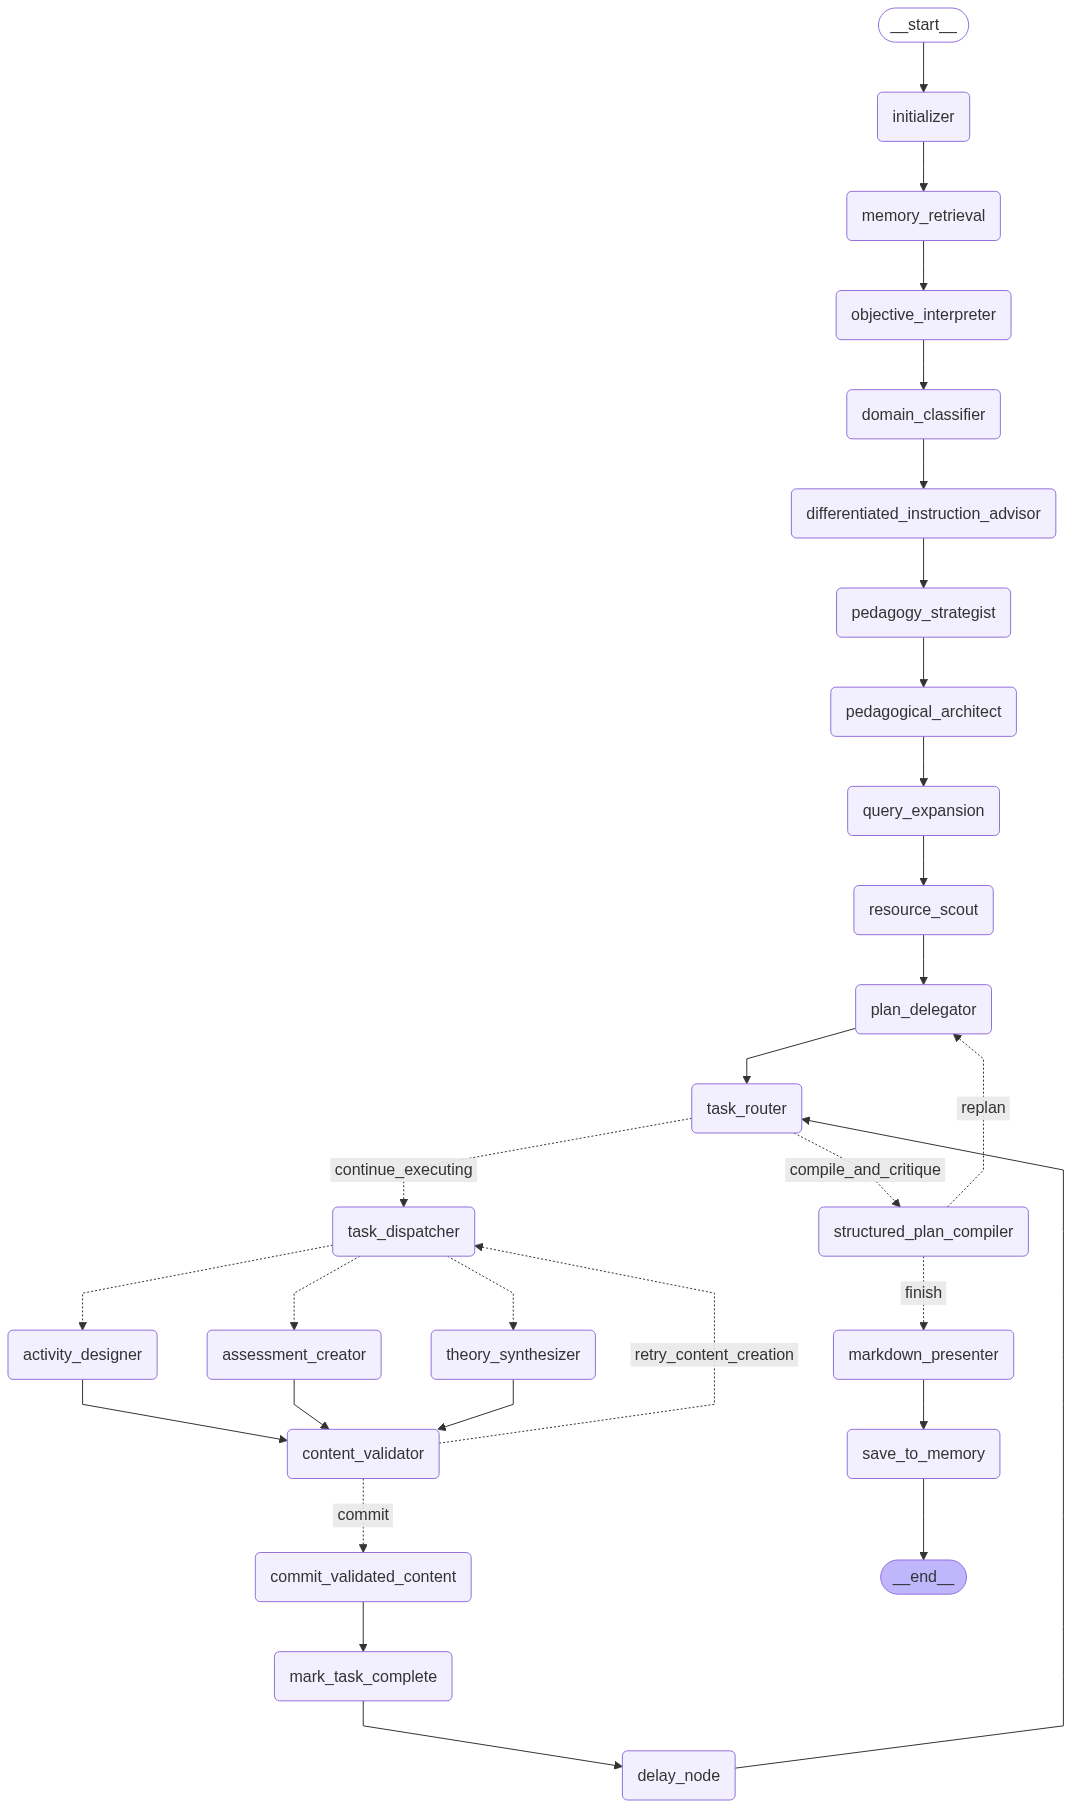

In [36]:
# ==============================================================================
# CELL 4.4: HIỂN THỊ SƠ ĐỒ GRAPH (TÙY CHỌN)
# ==============================================================================
try:
    # Lệnh này sẽ vẽ một sơ đồ của workflow, rất hữu ích để gỡ lỗi
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Lỗi vẽ biểu đồ: {e}. Đây là lỗi không nghiêm trọng, bạn vẫn có thể chạy quy trình.")

## PHẦN 5

In [37]:
# ==============================================================================
# CELL 5.1: ĐỊNH NGHĨA HÀM CHẠY QUY TRÌNH
# ==============================================================================
async def run_architect(user_request: str):
    if 'llm' not in globals() or llm is None:
        print_warning("LLM chưa được khởi tạo. Vui lòng chạy lại Cell 1.3.")
        return
    if 'vector_store' not in globals() or vector_store is None:
        print_warning("Kho tri thức chưa được tải. Vui lòng chạy lại Cell 1.4.")
        return
    if 'app' not in globals():
        print_warning("Graph 'app' chưa được biên dịch. Vui lòng chạy lại Cell 4.3.")
        return

    initial_state = {"messages": [HumanMessage(content=user_request)]}
    console.print(f"\n[bold magenta]🚀 BẮT ĐẦU QUY TRÌNH V7.1 (THE ARCHITECT) VỚI YÊU CẦU:[/bold magenta]\n> {user_request}")
    config = {"recursion_limit": 150} 
    
    final_state_result = None
    try:
        async for event in app.astream(initial_state, config=config):
            for node_name, node_output in event.items():
                console.print(f"\n[bold yellow]------- Hoàn thành bước: {node_name} -------[/bold yellow]")
                final_state_result = node_output

        console.print("\n[bold magenta]🏁 KẾT THÚC QUY TRÌNH V7.1.[/bold magenta]")
        
        if final_state_result and final_state_result.get("final_markdown_plan"):
            console.print("\n[bold green]📝 GIÁO ÁN HOÀN CHỈNH (v9.0)[/bold green]")
            console.print(Markdown(final_state_result["final_markdown_plan"]))
            
            # (Tùy chọn) In ra cả JSON để kiểm tra
            if VERBOSE_MODE:
                print_result(final_state_result.get("final_structured_plan"), "Output JSON có cấu trúc")

        else:
            print_warning("Không tạo được giáo án cuối cùng. Có thể Critic đã yêu cầu làm lại nhưng hết giới hạn đệ quy.")
            print("\nTrạng thái cuối cùng để gỡ lỗi:")
            pprint(final_state_result)
            
    except Exception as e:
        print_warning(f"Đã xảy ra lỗi nghiêm trọng trong quá trình chạy graph: {e}")
        import traceback
        traceback.print_exc()

print("✅ Hàm `run_architect` đã sẵn sàng để sử dụng.")

✅ Hàm `run_architect` đã sẵn sàng để sử dụng.


In [38]:
# ==============================================================================
# CELL 5.2: KÍCH HOẠT CHẠY THỬ NGHIỆM
# ==============================================================================
# Yêu cầu để kiểm tra
architect_request = "Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao."
VERBOSE_MODE = True 

# Chạy quy trình đã được cải cách
# Lưu ý: bạn cần một môi trường hỗ trợ `await` ở cấp độ cao nhất (như Jupyter Notebook)
await run_architect(architect_request)

🚀 BẮT ĐẦU QUY TRÌNH V7.1 (THE ARCHITECT) VỚI YÊU CẦU:
> Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là
một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao.

> `Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...

------- Hoàn thành bước: initializer -------

> `Agent: Memory Retrieval` (v9.4) đang tìm kiếm trong trí nhớ...

⚠️  Không có Trí nhớ Dài hạn. Bỏ qua bước này.

------- Hoàn thành bước: memory_retrieval -------

> `Agent: Objective Interpreter` (v7.5) đang phân tích mục tiêu...

✔️ Mục tiêu & Ràng buộc đã phân tích:

{
│   'action_verb': 'thiết kế',
│   'bloom_level': 2,
│   'topic': 'Đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'grade_level': 'lớp 9',
│   'constraints': {
│   │   'duration_minutes': 90
│   }
}

------- Hoàn thành bước: objective_interpreter -------

> `Agent: Domain Classifier` (v7.5) đang xác định lĩnh vực chuyên môn...

✔️ Lĩnh vực chuyên môn được xác định:

'Toán học'

------- Hoàn thành bước: domain_classifier -------

> `Agent: Differentiated Instruction Advisor` (v9.1) đang phân tích và đề xuất chiến lược phân hóa...

✔️ Hồ sơ lớp học và Chiến lược Phân hóa:

{
│   'learning_pace': 'chậm',
│   'engagement_style': 'thụ động',
│   'special_notes': 'Lớp học có tốc độ tiếp thu chậm, học sinh dễ mất tập trung và cần các hoạt động tương tác để duy trì sự chú ý.',
│   'differentiation_strategy': {
│   │   'for_struggling_students': 'Chia nhỏ kiến thức thành các phần nhỏ, sử dụng nhiều ví dụ minh họa trực quan, cung cấp phiếu bài tập có gợi ý hoặc công thức mẫu. Thường xuyên kiểm tra mức độ hiểu bài và hỗ trợ cá nhân kịp thời. Khuyến khích làm việc nhóm nhỏ để hỗ trợ lẫn nhau.',
│   │   'for_advanced_students': 'Giao các bài tập nâng cao, yêu cầu chứng minh các tính chất phức tạp hơn hoặc giải các bài toán ứng dụng thực tế. Khuyến khích các em tự tìm hiểu thêm về các định lý liên quan hoặc các trường hợp đặc biệt. Cho phép các em hỗ trợ bạn bè nhưng vẫn đảm bảo được thử thách cá nhân.'
│   }
}

------- Hoàn thành bước: differentiated_instruction_advisor -------

> `Agent: Pedagogy Strategist` (v7.5) đang xây dựng chiến lược sư phạm chi tiết...

✔️ Chiến lược sư phạm chi tiết:

{
│   'name': 'Dạy học hợp tác (Cooperative Learning)',
│   'rationale': 'Phương pháp dạy học hợp tác rất phù hợp với lớp học có tốc độ tiếp thu chậm và học sinh dễ mất tập trung. Việc làm việc nhóm giúp học sinh chủ động hơn trong học tập, tăng cường tương tác và hỗ trợ lẫn nhau, từ đó duy trì sự chú ý và tiếp thu kiến thức hiệu quả hơn. Học sinh yếu được bạn bè giúp đỡ, học sinh khá giỏi có cơ hội củng cố kiến thức và phát triển kỹ năng giải thích, hướng dẫn. Điều này cũng giúp giáo viên dễ dàng áp dụng chiến lược phân hóa đã đề ra, đảm bảo mọi học sinh đều đạt được mục tiêu bài học.',
│   'key_actions': [
│   │   'Giới thiệu khái niệm cơ bản và mục tiêu bài học',
│   │   'Chia học sinh thành các nhóm nhỏ và phân công nhiệm vụ cụ thể (ví dụ: nhóm 1 tìm hiểu định nghĩa, nhóm 2 tìm hiểu tính chất, nhóm 3 thực hành vẽ)',
│   │   'Học sinh làm việc nhóm, thảo luận, trao đổi và thực hành các nhiệm vụ được giao',
│   │   'Giáo viên quan sát, hỗ trợ, gợi ý và giải đáp thắc mắc cho từng nhóm',
│   │   'Đại diện các nhóm trình bày kết quả, sản phẩm của nhóm mình trước lớp',
│   │   'Cả lớp cùng nhận xét, bổ sung và giáo viên tổng kết, hệ thống hóa kiến thức',
│   │   'Giao bài tập củng cố và bài tập nâng cao phù hợp với từng đối tượng học sinh'
│   ]
}

------- Hoàn thành bước: pedagogy_strategist -------

> `Agent: Pedagogical Architect` (v9.4) đang thiết kế kịch bản buổi học...

✔️ Bản thiết kế Sư phạm đã được tạo:

[
│   'Khởi động và Đặt vấn đề: Giáo viên đặt câu hỏi gợi mở về đường tròn và tam giác, chiếu hình ảnh/video minh họa các vật thể có hình dạng đường tròn ngoại tiếp/nội tiếp. Chia lớp thành các nhóm nhỏ (3-4 học sinh). Phát phiếu học tập số 1 yêu cầu các nhóm thảo luận về định nghĩa ban đầu và cách nhận biết cơ bản qua hình ảnh.',
│   "Khám phá và Xây dựng kiến thức: Các nhóm nhận phiếu học tập số 2. Phiếu này bao gồm các nhiệm vụ cụ thể: tìm hiểu định nghĩa chi tiết, tính chất, và thực hành 'thiết kế' (xác định) tâm và bán kính của đường tròn ngoại tiếp/nội tiếp tam giác bằng cách vẽ hình. Giáo viên đi từng nhóm quan sát, gợi ý, giải đáp thắc mắc, đảm bảo mọi thành viên đều tham gia và hỗ trợ lẫn nhau. Đối với học sinh yếu, có thể cung cấp gợi ý hoặc công thức mẫu. Đối với học sinh khá giỏi, yêu cầu chứng minh các tính chất đơn giản.",
│   "Vận dụng và Trình bày sản phẩm: Các nhóm hoàn thành các bài tập vận dụng trong phiếu học tập số 3. Các bài tập này yêu cầu học sinh áp dụng kiến thức để giải quyết các tình huống cụ thể hoặc 'thiết kế' các hình vẽ phức tạp hơn. Đại diện 1-2 nhóm lên bảng trình bày cách giải/cách vẽ của nhóm mình. Các nhóm khác nhận xét, bổ sung. Giáo viên tổng kết, chuẩn hóa kiến thức, nhấn mạnh các lỗi thường gặp và các điểm cần lưu ý.",
│   'Củng cố và Mở rộng: Giáo viên giao bài tập về nhà phân hóa: bài tập cơ bản để củng cố cho tất cả học sinh, và bài tập nâng cao/ứng dụng thực tế cho học sinh khá giỏi. Khuyến khích học sinh tìm hiểu thêm về các trường hợp đặc biệt hoặc các ứng dụng của đường tròn ngoại tiếp/nội tiếp trong thực tế cuộc sống hoặc các lĩnh vực khác.'
]

------- Hoàn thành bước: pedagogical_architect -------

> `Agent: Query Expansion` (v7.5) đang phân tích yêu cầu...

✔️ Các truy vấn tìm kiếm đã được mở rộng:

[
│   'đường tròn ngoại tiếp và nội tiếp',
│   'công thức tính bán kính đường tròn ngoại tiếp tam giác',
│   'công thức tính bán kính đường tròn nội tiếp tam giác',
│   'tâm đường tròn ngoại tiếp tam giác là gì',
│   'tâm đường tròn nội tiếp tam giác là gì',
│   'bài tập đường tròn ngoại tiếp và nội tiếp lớp 9',
│   'chuyên đề đường tròn ngoại tiếp nội tiếp',
│   'đường tròn ngoại tiếp tam giác vuông',
│   'đường tròn nội tiếp tam giác đều',
│   'mối liên hệ giữa đường tròn ngoại tiếp và nội tiếp',
│   'cách vẽ đường tròn ngoại tiếp tam giác',
│   'cách vẽ đường tròn nội tiếp tam giác',
│   'ứng dụng của đường tròn ngoại tiếp nội tiếp trong hình học',
│   'lý thuyết đường tròn ngoại tiếp nội tiếp',
│   'phân biệt đường tròn ngoại tiếp và nội tiếp'
]

------- Hoàn thành bước: query_expansion -------

> `Agent: Resource Scout` (v8.1 - Sửa lỗi) đang tìm kiếm và sàng lọc...

> Tìm thấy 75 tài liệu, sàng lọc còn 8 đoạn văn bản độc nhất.

✔️ Tài liệu RAG cuối cùng:

{
│   'source': 'Sách giáo khoa (từ RAG - đã sàng lọc)',
│   'summary': 'Chào các em, với vai trò là một giáo viên giàu kinh nghiệm, thầy/cô sẽ tổng hợp kiến thức cốt lõi về chủ đề "Đường tròn ngoại tiếp và đường tròn nội tiếp" dựa **chỉ** vào các đoạn văn bản mà chúng ta có.\n\n---\n\n**TÓM TẮT KIẾN THỨC CỐT LÕI VỀ ĐƯỜNG TRÒN NGOẠI TIẾP VÀ ĐƯỜNG TRÒN NỘI TIẾP**\n\nDựa trên các đoạn văn bản được cung cấp, chúng ta có thể suy luận được một số kiến thức về đường tròn ngoại tiếp, trong khi thông tin về đường tròn nội tiếp không được đề cập.\n\n**1. Về Đường tròn ngoại tiếp**\n\n*   **1.1. Định nghĩa (Suy luận từ Bài 5.2 và Bài 5.4a):**\n    *   Đường tròn ngoại tiếp một đa giác là đường tròn đi qua tất cả các đỉnh của đa giác đó. Các ví dụ được đề cập trong bài tập là đường tròn ngoại tiếp tam giác (Bài 5.2) và đường tròn ngoại tiếp hình vuông (Bài 5.4a).\n\n*   **1.2. Xác định tâm và bán kính (Suy luận từ Bài 5.2, Bài 5.4a, Bài 5.4b):**\n    *   **Đối với tam giác vuông (Bài 5.2):** Các đỉnh của tam giác vuông thuộc cùng một đường tròn. Bán kính của đường tròn này có thể được tính toán.\n    *   **Đối với hình vuông (Bài 5.4a, Bài 5.4b):**\n        *   Có một đường tròn đi qua bốn đỉnh của hình vuông.\n        *   Tâm của đường tròn này là giao điểm của hai đường chéo của hình vuông (ví dụ: điểm E trong Bài 5.4a).\n        *   Tâm này cũng là tâm đối xứng của đường tròn.\n        *   Các đường chéo của hình vuông và các đường thẳng đi qua tâm và trung điểm các cạnh đối diện là các trục đối xứng của đường tròn.\n        *   Bán kính của đường tròn có thể tính được nếu biết độ dài cạnh của hình vuông.\n\n**2. Về Đường tròn nội tiếp**\n\n*   **2.1. Thông tin trong văn bản:**\n    *   Các đoạn văn bản được cung cấp không chứa thông tin về định nghĩa hay tính chất của đường tròn nội tiếp. Do đó, không thể tổng hợp kiến thức về chủ đề này dựa trên nguồn tài liệu hiện có.\n\n---\nHy vọng bản tóm tắt này giúp các em nắm được những điểm cốt lõi từ các bài tập và đoạn văn bản đã cho.'
}

------- Hoàn thành bước: resource_scout -------

> `Agent: Plan Delegator` (v10.0 - Nhà hoạch định Thông thái) đang triển khai...

✔️ Đã tạo 4 nhiệm vụ chi tiết:

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động và Đặt vấn đề',
│   │   'task_description': 'Giáo viên đặt câu hỏi gợi mở về đường tròn và tam giác, chiếu hình ảnh/video minh họa các vật thể có hình dạng đường tròn ngoại tiếp/nội tiếp. Chia lớp thành các nhóm nhỏ (3-4 học sinh). Phát phiếu học tập số 1 yêu cầu các nhóm thảo luận về định nghĩa ban đầu và cách nhận biết cơ bản qua hình ảnh.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Khám phá và Xây dựng kiến thức',
│   │   'task_description': "Các nhóm nhận phiếu học tập số 2. Phiếu này bao gồm các nhiệm vụ cụ thể: tìm hiểu định nghĩa chi tiết, tính chất, và thực hành 'thiết kế' (xác định) tâm và bán kính của đường tròn ngoại tiếp/nội tiếp tam giác bằng cách vẽ hình. Giáo viên đi từng nhóm quan sát, gợi ý, giải đáp thắc mắc, đảm bảo mọi thành viên đều tham gia và hỗ trợ lẫn nhau. Đối với học sinh yếu, có thể cung cấp gợi ý hoặc công thức mẫu. Đối với học sinh khá giỏi, yêu cầu chứng minh các tính chất đơn giản.",
│   │   'estimated_duration': 45,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Vận dụng và Trình bày sản phẩm',
│   │   'task_description': "Các nhóm hoàn thành các bài tập vận dụng trong phiếu học tập số 3. Các bài tập này yêu cầu học sinh áp dụng kiến thức để giải quyết các tình huống cụ thể hoặc 'thiết kế' các hình vẽ phức tạp hơn. Đại diện 1-2 nhóm lên bảng trình bày cách giải/cách vẽ của nhóm mình. Các nhóm khác nhận xét, bổ sung. Giáo viên tổng kết, chuẩn hóa kiến thức, nhấn mạnh các lỗi thường gặp và các điểm cần lưu ý.",
│   │   'estimated_duration': 30,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Củng cố và Mở rộng',
│   │   'task_description': 'Giáo viên giao bài tập về nhà phân hóa: bài tập cơ bản để củng cố cho tất cả học sinh, và bài tập nâng cao/ứng dụng thực tế cho học sinh khá giỏi. Khuyến khích học sinh tìm hiểu thêm về các trường hợp đặc biệt hoặc các ứng dụng của đường tròn ngoại tiếp/nội tiếp trong thực tế cuộc sống hoặc các lĩnh vực khác.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động và Đặt vấn đề' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khởi động và Đặt vấn đề',
│   'activity_type': 'Hoạt động cá nhân và chia sẻ chung',
│   'duration_minutes': 10,
│   'teacher_actions': [
│   │   'Giới thiệu mục tiêu hoạt động khởi động và đặt vấn đề.',
│   │   'Trình bày câu hỏi/tình huống gợi mở (có thể dùng hình ảnh/video ngắn).',
│   │   'Hướng dẫn học sinh suy nghĩ cá nhân và thảo luận cặp/nhóm nhỏ.',
│   │   'Quan sát, lắng nghe, đi lại giữa các nhóm để hỗ trợ và gợi ý.',
│   │   'Mời đại diện một vài nhóm/cá nhân chia sẻ ý kiến trước lớp.',
│   │   'Tổng kết các ý kiến, dẫn dắt vào nội dung bài học mới.'
│   ],
│   'core_component': 'Học sinh suy nghĩ cá nhân (2 phút) về một câu hỏi/tình huống gợi mở liên quan đến chủ đề bài học mới. Sau đó, chia sẻ nhanh ý kiến của mình với bạn bên cạnh hoặc trong nhóm nhỏ (3 phút) và chuẩn bị 1-2 ý kiến để chia sẻ trước lớp (5 phút).',
│   'extension_component': 'Nếu còn thời gian, học sinh có thể suy nghĩ thêm về các ví dụ thực tế khác liên quan đến câu hỏi/tình huống đã cho, hoặc đặt ra một câu hỏi mà các em muốn được giải đáp trong bài học chính thức.',
│   'solution_guide': "Các câu hỏi gợi mở có thể bao gồm: 'Bạn đã từng gặp tình huống tương tự ở đâu?', 'Bạn nghĩ điều gì sẽ xảy ra nếu...?', 'Theo bạn, tại sao vấn đề này lại quan trọng?'. Mục tiêu là khơi gợi sự tò mò, kết nối kiến thức nền của học sinh và tạo động lực học tập cho bài mới.",
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên có thể cung cấp các câu hỏi gợi ý cụ thể hơn, từ khóa hoặc cho phép học sinh chỉ cần nêu một từ/cụm từ ngắn gọn. Khuyến khích các em lắng nghe ý kiến của bạn và bổ sung.',
│   │   'for_advanced_students': 'Khuyến khích học sinh suy nghĩ về nhiều khía cạnh của vấn đề, liên hệ với kiến thức đã học hoặc các vấn đề xã hội rộng hơn. Yêu cầu các em đặt câu hỏi phản biện hoặc đề xuất giải pháp ban đầu.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh suy nghĩ cá nhân (2 phút) về một câu hỏi/tình huống gợi mở liên quan đến chủ đề bài học mới. Sau đó, chia sẻ nhanh ý kiến của mình với bạn bên cạnh hoặc trong nhóm nhỏ (3 phút) và chuẩn bị 1-2 ý kiến để chia sẻ trước lớp (5 phút).\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian, học sinh có thể suy nghĩ thêm về các ví dụ thực tế khác liên quan đến câu hỏi/tình huống đã cho, hoặc đặt ra một câu hỏi mà các em muốn được giải đáp trong bài học chính thức.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này có cấu trúc khá tốt nhưng không thực tế để hoàn thành trong 10 phút. Phần cốt
lõi dành cho học sinh đã chiếm trọn 10 phút (2 phút cá nhân + 3 phút nhóm + 5 phút chia sẻ trước lớp), chưa tính 
thời gian giáo viên giới thiệu, trình bày câu hỏi, hướng dẫn, và đặc biệt là tổng kết, dẫn dắt vào bài mới. Để đảm 
bảo hiệu quả và tuân thủ thời gian, hoạt động cần được tinh gọn hơn. Hãy thiết kế lại một phiên bản hoạt động đơn 
giản hơn, ít bước hơn để khớp với thời gian 10 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khởi động và Đặt vấn đề: "Thức tỉnh"',
│   'activity_type': 'Thảo luận nhanh và Đặt vấn đề',
│   'duration_minutes': 10,
│   'teacher_actions': [
│   │   'Chuẩn bị kỹ lưỡng hình ảnh/video/tin tức/câu chuyện gây ấn tượng, phù hợp với chủ đề bài học.',
│   │   'Đặt câu hỏi gợi mở rõ ràng, ngắn gọn và dễ hiểu.',
│   │   'Quản lý thời gian chặt chẽ cho từng phần hoạt động (giới thiệu, suy nghĩ cá nhân, chia sẻ, tổng kết).',
│   │   'Lắng nghe tích cực và tóm tắt nhanh các ý kiến của học sinh.',
│   │   'Dẫn dắt khéo léo từ các ý kiến học sinh đến mục tiêu và nội dung chính của bài học mới.'
│   ],
│   'core_component': 'Giáo viên trình chiếu một hình ảnh/video ngắn (khoảng 30 giây) hoặc một câu chuyện/tin tức gây ấn tượng mạnh về một vấn đề thời sự (ví dụ: ô nhiễm môi trường, biến đổi khí hậu, một sự kiện lịch sử nổi bật, v.v.) liên quan đến bài học. Sau đó, giáo viên đặt câu hỏi: "Bạn có suy nghĩ, cảm xúc gì khi chứng kiến/nghe thấy điều này? Theo bạn, vấn đề này có ý nghĩa gì đối với cuộc sống của chúng ta?". Học sinh có 1 phút để suy nghĩ cá nhân. Giáo viên mời 3-4 học sinh xung phong chia sẻ nhanh ý kiến của mình trước lớp (mỗi em khoảng 1 phút). Cuối cùng, giáo viên tổng hợp các ý kiến, dẫn dắt khéo léo vào vấn đề chính của bài học, nêu rõ mục tiêu cần tìm hiểu trong bài mới.',
│   'extension_component': 'Nếu còn thời gian, giáo viên có thể đặt thêm một câu hỏi phụ mang tính dự đoán hoặc giải pháp: "Theo bạn, điều gì sẽ xảy ra nếu chúng ta không giải quyết vấn đề này?" hoặc "Chúng ta có thể làm gì để góp phần giải quyết vấn đề này?".',
│   'solution_guide': 'Hoạt động này không có "đáp án" cụ thể mà là sự đa dạng trong suy nghĩ và cảm xúc của học sinh. Giáo viên cần định hướng để các ý kiến tập trung vào việc nhận diện vấn đề, tầm quan trọng của nó và sự liên quan đến cuộc sống, từ đó dẫn dắt vào bài học mới.',
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên có thể gợi ý các từ khóa hoặc câu hỏi đơn giản hơn để các em dễ dàng bắt đầu suy nghĩ. Có thể cho các em chia sẻ theo cặp nhanh trước khi chia sẻ trước lớp để tăng sự tự tin.',
│   │   'for_advanced_students': 'Khuyến khích các em liên hệ vấn đề với các kiến thức đã học hoặc đề xuất các giải pháp ban đầu (nếu phù hợp với chủ đề) để kích thích tư duy sâu hơn.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nGiáo viên trình chiếu một hình ảnh/video ngắn (khoảng 30 giây) hoặc một câu chuyện/tin tức gây ấn tượng mạnh về một vấn đề thời sự (ví dụ: ô nhiễm môi trường, biến đổi khí hậu, một sự kiện lịch sử nổi bật, v.v.) liên quan đến bài học. Sau đó, giáo viên đặt câu hỏi: "Bạn có suy nghĩ, cảm xúc gì khi chứng kiến/nghe thấy điều này? Theo bạn, vấn đề này có ý nghĩa gì đối với cuộc sống của chúng ta?". Học sinh có 1 phút để suy nghĩ cá nhân. Giáo viên mời 3-4 học sinh xung phong chia sẻ nhanh ý kiến của mình trước lớp (mỗi em khoảng 1 phút). Cuối cùng, giáo viên tổng hợp các ý kiến, dẫn dắt khéo léo vào vấn đề chính của bài học, nêu rõ mục tiêu cần tìm hiểu trong bài mới.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian, giáo viên có thể đặt thêm một câu hỏi phụ mang tính dự đoán hoặc giải pháp: "Theo bạn, điều gì sẽ xảy ra nếu chúng ta không giải quyết vấn đề này?" hoặc "Chúng ta có thể làm gì để góp phần giải quyết vấn đề này?".'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

> ✔️ GUARDIAN: Nội dung tuân thủ kế hoạch!

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khám phá và Xây dựng kiến thức' (ID: 1)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá và Xây dựng kiến thức',
│   'activity_type': 'Thảo luận nhóm và Thực hành cá nhân',
│   'duration_minutes': 45,
│   'teacher_actions': [
│   │   'Giới thiệu mục tiêu và hướng dẫn chi tiết hoạt động.',
│   │   'Phát tài liệu/phiếu học tập cho học sinh.',
│   │   'Quan sát, lắng nghe các nhóm thảo luận, đặt câu hỏi gợi mở để định hướng tư duy.',
│   │   'Hỗ trợ các nhóm gặp khó khăn bằng cách cung cấp gợi ý hoặc giải thích thêm.',
│   │   'Tổng kết các ý chính, chốt kiến thức trọng tâm sau khi các nhóm trình bày.'
│   ],
│   'core_component': 'Học sinh đọc một đoạn văn/tài liệu ngắn (khoảng 1-2 trang) về một chủ đề cụ thể (ví dụ: khái niệm khoa học, sự kiện lịch sử, vấn đề xã hội). Sau đó, cá nhân học sinh ghi lại các từ khóa, ý chính và câu hỏi thắc mắc. Tiếp theo, học sinh chia nhóm (3-4 người) để thảo luận, chia sẻ những gì đã khám phá, cùng nhau giải đáp thắc mắc và xây dựng một bản tóm tắt hoặc sơ đồ tư duy về chủ đề đó. Cuối cùng, một vài nhóm sẽ trình bày nhanh kết quả của mình.',
│   'extension_component': 'Nếu còn thời gian hoặc đối với học sinh hoàn thành nhanh, yêu cầu học sinh áp dụng kiến thức vừa học để giải quyết một bài tập nhỏ, tạo một ví dụ minh họa cụ thể, hoặc tự tìm kiếm thêm một thông tin liên quan đến chủ đề từ sách giáo khoa/internet và chia sẻ với nhóm.',
│   'solution_guide': "Các ý chính cần đạt được từ đoạn văn/tình huống: (Liệt kê các ý chính dự kiến). Các câu hỏi gợi mở để học sinh tự kiểm tra hiểu biết: 'Bạn đã học được điều gì mới từ đoạn văn này?', 'Bạn có thể giải thích khái niệm X bằng lời của mình không?', 'Vấn đề Y có ý nghĩa gì trong bối cảnh hiện tại?'",
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp phiếu học tập có cấu trúc rõ ràng hơn, các câu hỏi gợi ý cụ thể hoặc danh sách từ khóa quan trọng. Khuyến khích làm việc cặp đôi với bạn khá hơn. Giáo viên dành thời gian hỗ trợ trực tiếp, giải thích lại các khái niệm khó.',
│   │   'for_advanced_students': 'Yêu cầu phân tích sâu hơn về nguyên nhân/hậu quả, liên hệ với các kiến thức đã học hoặc các vấn đề thực tiễn. Đặt câu hỏi phản biện hoặc yêu cầu tìm kiếm thêm thông tin từ các nguồn khác để mở rộng vấn đề.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh đọc một đoạn văn/tài liệu ngắn (khoảng 1-2 trang) về một chủ đề cụ thể (ví dụ: khái niệm khoa học, sự kiện lịch sử, vấn đề xã hội). Sau đó, cá nhân học sinh ghi lại các từ khóa, ý chính và câu hỏi thắc mắc. Tiếp theo, học sinh chia nhóm (3-4 người) để thảo luận, chia sẻ những gì đã khám phá, cùng nhau giải đáp thắc mắc và xây dựng một bản tóm tắt hoặc sơ đồ tư duy về chủ đề đó. Cuối cùng, một vài nhóm sẽ trình bày nhanh kết quả của mình.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian hoặc đối với học sinh hoàn thành nhanh, yêu cầu học sinh áp dụng kiến thức vừa học để giải quyết một bài tập nhỏ, tạo một ví dụ minh họa cụ thể, hoặc tự tìm kiếm thêm một thông tin liên quan đến chủ đề từ sách giáo khoa/internet và chia sẻ với nhóm.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này có cấu trúc tốt và phù hợp về mặt sư phạm, tuy nhiên, với nhiều bước như đọc 
tài liệu cá nhân, ghi chú, thảo luận nhóm, xây dựng sản phẩm (tóm tắt/sơ đồ tư duy) và sau đó là trình bày của các 
nhóm, tổng thời lượng 45 phút là không đủ để hoàn thành một cách hiệu quả. Mỗi bước đều cần thời gian nhất định để 
học sinh thực sự khám phá và xây dựng kiến thức. Hãy thiết kế lại một phiên bản hoạt động đơn giản hơn, ít bước hơn
để khớp với thời gian 45 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá và Xây dựng kiến thức',
│   'activity_type': 'Thảo luận nhóm và Tổng hợp kiến thức',
│   'duration_minutes': 45,
│   'teacher_actions': [
│   │   'Giới thiệu mục tiêu hoạt động và phân chia nhóm.',
│   │   'Phát tài liệu và câu hỏi trọng tâm cho từng nhóm.',
│   │   'Quan sát, lắng nghe các nhóm thảo luận, gợi ý khi cần thiết (không can thiệp sâu vào quá trình khám phá của học sinh).',
│   │   'Quản lý thời gian, nhắc nhở các nhóm chuyển giai đoạn.',
│   │   'Tổ chức phần chia sẻ nhanh của các nhóm (mỗi nhóm 1-2 phút).',
│   │   'Tổng kết các ý chính, chốt kiến thức và giải đáp thắc mắc.'
│   ],
│   'core_component': 'Học sinh làm việc theo nhóm (3-4 người). Mỗi nhóm nhận một đoạn văn bản ngắn (hoặc một hình ảnh/biểu đồ) chứa thông tin trọng tâm về chủ đề. Nhiệm vụ của nhóm là: 1. Đọc nhanh và thảo luận để xác định 2-3 ý chính/khái niệm quan trọng nhất từ tài liệu. 2. Thống nhất và ghi lại 1-2 câu trả lời ngắn gọn cho câu hỏi trọng tâm do giáo viên đưa ra (ví dụ: "Điều quan trọng nhất bạn học được từ tài liệu này là gì?" hoặc "Hãy nêu 2 tác động chính của X lên Y?"). 3. Chuẩn bị để một thành viên đại diện nhóm chia sẻ nhanh kết quả trong 1-2 phút.',
│   'extension_component': 'Nếu nhóm hoàn thành sớm, hãy yêu cầu các em tìm thêm một ví dụ thực tế minh họa cho một trong các ý chính đã tìm được hoặc đặt một câu hỏi mở rộng liên quan đến chủ đề để thách thức các nhóm khác.',
│   'solution_guide': 'Các ý chính cần đạt được từ tài liệu: (Liệt kê 2-3 ý chính dự kiến). Câu hỏi gợi mở: "Tại sao ý này lại quan trọng?", "Bạn có thể liên hệ điều này với kiến thức nào đã học?"',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp tài liệu đơn giản hơn, có gạch chân các từ khóa quan trọng hoặc câu hỏi gợi mở cụ thể hơn. Ghép nhóm với học sinh khá để nhận được sự hỗ trợ từ bạn bè.',
│   │   'for_advanced_students': 'Yêu cầu phân tích sâu hơn một ý chính, liên hệ kiến thức với các vấn đề thực tiễn, hoặc đặt câu hỏi phản biện cho các nhóm khác sau khi chia sẻ.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh làm việc theo nhóm (3-4 người). Mỗi nhóm nhận một đoạn văn bản ngắn (hoặc một hình ảnh/biểu đồ) chứa thông tin trọng tâm về chủ đề. Nhiệm vụ của nhóm là: 1. Đọc nhanh và thảo luận để xác định 2-3 ý chính/khái niệm quan trọng nhất từ tài liệu. 2. Thống nhất và ghi lại 1-2 câu trả lời ngắn gọn cho câu hỏi trọng tâm do giáo viên đưa ra (ví dụ: "Điều quan trọng nhất bạn học được từ tài liệu này là gì?" hoặc "Hãy nêu 2 tác động chính của X lên Y?"). 3. Chuẩn bị để một thành viên đại diện nhóm chia sẻ nhanh kết quả trong 1-2 phút.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu nhóm hoàn thành sớm, hãy yêu cầu các em tìm thêm một ví dụ thực tế minh họa cho một trong các ý chính đã tìm được hoặc đặt một câu hỏi mở rộng liên quan đến chủ đề để thách thức các nhóm khác.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động được thiết kế khá tốt và phù hợp với mục tiêu "Khám phá và Xây dựng kiến thức". 
Tuy nhiên, với thời lượng 45 phút, các bước được mô tả có vẻ quá chi tiết và sẽ rất khó để hoàn thành một cách hiệu
quả. Cụ thể, phần thảo luận nhóm để đọc, xác định ý chính, thống nhất câu trả lời và chuẩn bị chia sẻ sẽ cần nhiều 
thời gian hơn dự kiến. Sau đó, việc tổ chức cho nhiều nhóm cùng chia sẻ (mỗi nhóm 1-2 phút) cũng sẽ chiếm một phần 
đáng kể thời gian còn lại. Điều này có thể khiến hoạt động bị gấp gáp, ảnh hưởng đến chất lượng khám phá và tổng 
hợp kiến thức của học sinh. Hãy thiết kế lại một phiên bản hoạt động đơn giản hơn, ít bước hơn để khớp với thời 
gian 45 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá và Xây dựng kiến thức',
│   'activity_type': 'Hoạt động nhóm và Tổng hợp kiến thức',
│   'duration_minutes': 45,
│   'teacher_actions': [
│   │   'Giới thiệu mục tiêu hoạt động và phân chia nhóm (5 phút).',
│   │   'Phát tài liệu và câu hỏi trọng tâm cho từng nhóm (2 phút).',
│   │   'Đi quanh các nhóm, quan sát, lắng nghe, và gợi ý khi cần thiết (không giải đáp trực tiếp mà đặt câu hỏi mở) (20 phút).',
│   │   'Quản lý thời gian chặt chẽ cho từng giai đoạn.',
│   │   "Tổ chức phần chia sẻ nhanh của các nhóm (chọn ngẫu nhiên 2-3 nhóm hoặc yêu cầu các nhóm chia sẻ ý chính theo hình thức 'popcorn') (10 phút).",
│   │   'Tổng hợp các ý kiến, chốt lại kiến thức cốt lõi và giải đáp thắc mắc (nếu có) (8 phút).'
│   ],
│   'core_component': 'Học sinh làm việc theo nhóm (3-4 người). Mỗi nhóm sẽ được cung cấp một đoạn văn bản ngắn (hoặc một tình huống/ví dụ cụ thể) liên quan đến chủ đề đang học. Nhiệm vụ của nhóm là đọc nhanh, thảo luận để xác định một ý chính hoặc trả lời một câu hỏi trọng tâm duy nhất được giáo viên đưa ra. Mục tiêu là tổng hợp kiến thức cốt lõi từ tài liệu đã cho. Sau khi thảo luận, các nhóm chuẩn bị một câu trả lời ngắn gọn hoặc một ý chính để chia sẻ nhanh với cả lớp.',
│   'extension_component': 'Nếu hoàn thành sớm, các nhóm có thể tìm thêm một ví dụ thực tế khác minh họa cho ý chính vừa khám phá hoặc đặt một câu hỏi mở rộng cho cả lớp.',
│   'solution_guide': "Các ý chính/câu trả lời cần tập trung vào khái niệm/nguyên lý cốt lõi của bài học. Ví dụ: Nếu bài về 'Biến đổi khí hậu', ý chính có thể là 'Nguyên nhân chính gây biến đổi khí hậu là do hoạt động của con người' hoặc 'Hậu quả của biến đổi khí hậu là...'. Giáo viên cần có sẵn các đáp án mẫu hoặc các điểm cần đạt được để đối chiếu.",
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp tài liệu đơn giản hơn hoặc câu hỏi gợi ý cụ thể hơn. Giáo viên dành thời gian hỗ trợ trực tiếp, đặt câu hỏi dẫn dắt để giúp các em tìm ra ý chính.',
│   │   'for_advanced_students': 'Yêu cầu các em phân tích sâu hơn về mối liên hệ giữa ý chính vừa tìm được với các kiến thức đã học hoặc suy nghĩ về ứng dụng thực tiễn của kiến thức đó.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh làm việc theo nhóm (3-4 người). Mỗi nhóm sẽ được cung cấp một đoạn văn bản ngắn (hoặc một tình huống/ví dụ cụ thể) liên quan đến chủ đề đang học. Nhiệm vụ của nhóm là đọc nhanh, thảo luận để xác định một ý chính hoặc trả lời một câu hỏi trọng tâm duy nhất được giáo viên đưa ra. Mục tiêu là tổng hợp kiến thức cốt lõi từ tài liệu đã cho. Sau khi thảo luận, các nhóm chuẩn bị một câu trả lời ngắn gọn hoặc một ý chính để chia sẻ nhanh với cả lớp.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu hoàn thành sớm, các nhóm có thể tìm thêm một ví dụ thực tế khác minh họa cho ý chính vừa khám phá hoặc đặt một câu hỏi mở rộng cho cả lớp.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

> ✔️ GUARDIAN: Nội dung tuân thủ kế hoạch!

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Vận dụng và Trình bày sản phẩm' (ID: 2)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Vận dụng và Trình bày sản phẩm',
│   'activity_type': 'Thảo luận nhóm và Trình bày',
│   'duration_minutes': 30,
│   'teacher_actions': [
│   │   'Giới thiệu nhiệm vụ, mục tiêu và thời gian cụ thể cho từng phần (ví dụ: 20 phút làm việc nhóm, 10 phút trình bày).',
│   │   'Đi quanh các nhóm, quan sát tiến độ, lắng nghe thảo luận, gợi ý và hỗ trợ khi học sinh gặp khó khăn.',
│   │   'Quản lý thời gian trình bày của các nhóm, đảm bảo mỗi nhóm có đủ thời gian nhưng không vượt quá quy định.',
│   │   'Đưa ra nhận xét, đánh giá chung về các sản phẩm và bài trình bày, nhấn mạnh các điểm mạnh và gợi ý cải thiện.',
│   │   'Tổng kết lại kiến thức trọng tâm đã được vận dụng trong hoạt động và liên hệ thực tế.'
│   ],
│   'core_component': "Học sinh làm việc theo nhóm (đã được phân công hoặc tự chọn nhanh). Mỗi nhóm vận dụng kiến thức đã học (ví dụ: về một khái niệm, quy trình, hoặc vấn đề cụ thể) để tạo ra một 'sản phẩm' đơn giản (ví dụ: một sơ đồ tư duy tóm tắt, một poster nhỏ minh họa, một kế hoạch giải quyết vấn đề ngắn gọn, hoặc một đoạn kịch tình huống 1-2 phút). Sau đó, các nhóm chuẩn bị trình bày ngắn gọn (tối đa 3 phút/nhóm) về sản phẩm của mình, tập trung vào cách họ đã vận dụng kiến thức và ý nghĩa của sản phẩm.",
│   'extension_component': 'Các nhóm hoàn thành sớm có thể: 1. Hoàn thiện sản phẩm/bài trình bày chi tiết hơn, bổ sung thêm ví dụ hoặc minh chứng. 2. Chuẩn bị thêm các câu hỏi phản biện hoặc nhận xét mang tính xây dựng cho các nhóm khác. 3. Tìm kiếm các ứng dụng thực tế khác của kiến thức đã học hoặc mở rộng vấn đề đã giải quyết.',
│   'solution_guide': "Tiêu chí đánh giá sản phẩm/bài trình bày có thể bao gồm: tính rõ ràng, chính xác của kiến thức vận dụng; sự sáng tạo trong cách thể hiện; khả năng trình bày mạch lạc, tự tin; và ý nghĩa thực tiễn của sản phẩm. Các câu hỏi gợi mở khi học sinh trình bày: 'Các em đã vận dụng kiến thức nào để tạo ra sản phẩm này?', 'Sản phẩm này có ý nghĩa gì trong cuộc sống/thực tế?', 'Nếu có thêm thời gian, các em sẽ cải thiện sản phẩm như thế nào?'.",
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp các mẫu gợi ý, ví dụ minh họa đơn giản hoặc câu hỏi dẫn dắt cụ thể để các em dễ dàng bắt đầu và định hướng được sản phẩm. Giáo viên có thể dành thêm thời gian hỗ trợ trực tiếp nhóm này, chia nhỏ nhiệm vụ nếu cần.',
│   │   'for_advanced_students': 'Khuyến khích các em sáng tạo hơn trong sản phẩm (ví dụ: yêu cầu giải pháp độc đáo, phân tích sâu hơn), đặt ra các câu hỏi phản biện sâu hơn cho các nhóm khác, hoặc yêu cầu các em tìm kiếm các ứng dụng thực tế phức tạp hơn của kiến thức đã học.'
│   },
│   'question_or_description': "**Phần Cốt lõi:**\nHọc sinh làm việc theo nhóm (đã được phân công hoặc tự chọn nhanh). Mỗi nhóm vận dụng kiến thức đã học (ví dụ: về một khái niệm, quy trình, hoặc vấn đề cụ thể) để tạo ra một 'sản phẩm' đơn giản (ví dụ: một sơ đồ tư duy tóm tắt, một poster nhỏ minh họa, một kế hoạch giải quyết vấn đề ngắn gọn, hoặc một đoạn kịch tình huống 1-2 phút). Sau đó, các nhóm chuẩn bị trình bày ngắn gọn (tối đa 3 phút/nhóm) về sản phẩm của mình, tập trung vào cách họ đã vận dụng kiến thức và ý nghĩa của sản phẩm.\n\n**Phần Mở rộng (nếu còn thời gian):**\nCác nhóm hoàn thành sớm có thể: 1. Hoàn thiện sản phẩm/bài trình bày chi tiết hơn, bổ sung thêm ví dụ hoặc minh chứng. 2. Chuẩn bị thêm các câu hỏi phản biện hoặc nhận xét mang tính xây dựng cho các nhóm khác. 3. Tìm kiếm các ứng dụng thực tế khác của kiến thức đã học hoặc mở rộng vấn đề đã giải quyết."
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này có cấu trúc tốt và phù hợp về mặt sư phạm. Tuy nhiên, thời lượng 30 phút là 
quá eo hẹp để thực hiện đầy đủ các bước như mô tả, đặc biệt là phần trình bày của các nhóm (tối đa 3 phút/nhóm) và 
phần nhận xét, tổng kết của giáo viên. Với 20 phút làm việc nhóm và chỉ 10 phút còn lại cho cả trình bày và tổng 
kết, sẽ rất khó để đảm bảo tất cả các nhóm đều có cơ hội trình bày và giáo viên có đủ thời gian để đưa ra phản hồi 
chất lượng. Hãy thiết kế lại một phiên bản hoạt động đơn giản hơn, ít bước hơn để khớp với thời gian 30 phút đã 
cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Vận dụng và Trình bày sản phẩm',
│   'activity_type': 'Thảo luận nhóm và Trình bày nhanh',
│   'duration_minutes': 30,
│   'teacher_actions': [
│   │   'Giới thiệu nhiệm vụ, mục tiêu và thời gian cho hoạt động (3 phút).',
│   │   'Chia nhóm (nếu cần) và phát phiếu/tài liệu hướng dẫn.',
│   │   'Quan sát, hỗ trợ các nhóm trong quá trình làm việc, gợi ý khi cần thiết.',
│   │   'Chọn ngẫu nhiên 2-3 nhóm để trình bày nhanh sản phẩm của mình (mỗi nhóm tối đa 1.5-2 phút).',
│   │   'Tổng kết, nhận xét chung về các sản phẩm và quá trình làm việc của học sinh (2 phút).',
│   │   'Định hướng cho các hoạt động tiếp theo.'
│   ],
│   'core_component': 'Học sinh làm việc theo nhóm (4-5 người) trong 20 phút để vận dụng kiến thức đã học về [chủ đề cụ thể của bài học] nhằm: 1. Phân tích một tình huống/vấn đề thực tế được giáo viên cung cấp. 2. Đề xuất một giải pháp hoặc tạo ra một sản phẩm cụ thể (ví dụ: một sơ đồ tư duy tóm tắt, một đoạn văn ngắn trình bày quan điểm, một poster quảng bá ý tưởng, một kế hoạch hành động đơn giản) để giải quyết vấn đề hoặc thể hiện sự hiểu biết về chủ đề. 3. Chuẩn bị trình bày ngắn gọn (tối đa 1-2 phút) về sản phẩm của nhóm.',
│   'extension_component': 'Nếu hoàn thành sớm phần cốt lõi, các nhóm có thể: Suy nghĩ về các yếu tố bổ sung hoặc cải tiến cho sản phẩm/giải pháp của mình. Chuẩn bị thêm các câu hỏi phản biện cho các nhóm khác. Tìm kiếm các ví dụ thực tế khác liên quan đến chủ đề để minh họa thêm.',
│   'solution_guide': 'Các câu hỏi gợi mở/tiêu chí đánh giá sản phẩm: Sản phẩm có thể hiện rõ sự vận dụng kiến thức đã học không? Giải pháp/sản phẩm có tính khả thi và sáng tạo không? Cách trình bày có rõ ràng, mạch lạc và thuyết phục không? Các nhóm có thể tham khảo các ví dụ mẫu (nếu có) hoặc dàn ý cơ bản do giáo viên cung cấp.',
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên cung cấp các mẫu câu, gợi ý cụ thể hơn hoặc phiếu hỗ trợ có sẵn các từ khóa/cấu trúc. Ưu tiên ghép nhóm với học sinh khá giỏi để nhận được sự hỗ trợ từ bạn bè. Giáo viên dành thời gian quan tâm, hướng dẫn trực tiếp nhóm này.',
│   │   'for_advanced_students': 'Khuyến khích học sinh đào sâu vấn đề, đưa ra các giải pháp sáng tạo, phức tạp hơn hoặc liên hệ với các kiến thức liên môn. Yêu cầu nhóm chuẩn bị thêm phần phản biện hoặc mở rộng vấn đề.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh làm việc theo nhóm (4-5 người) trong 20 phút để vận dụng kiến thức đã học về [chủ đề cụ thể của bài học] nhằm: 1. Phân tích một tình huống/vấn đề thực tế được giáo viên cung cấp. 2. Đề xuất một giải pháp hoặc tạo ra một sản phẩm cụ thể (ví dụ: một sơ đồ tư duy tóm tắt, một đoạn văn ngắn trình bày quan điểm, một poster quảng bá ý tưởng, một kế hoạch hành động đơn giản) để giải quyết vấn đề hoặc thể hiện sự hiểu biết về chủ đề. 3. Chuẩn bị trình bày ngắn gọn (tối đa 1-2 phút) về sản phẩm của nhóm.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu hoàn thành sớm phần cốt lõi, các nhóm có thể: Suy nghĩ về các yếu tố bổ sung hoặc cải tiến cho sản phẩm/giải pháp của mình. Chuẩn bị thêm các câu hỏi phản biện cho các nhóm khác. Tìm kiếm các ví dụ thực tế khác liên quan đến chủ đề để minh họa thêm.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này có cấu trúc tốt và phù hợp về mặt sư phạm. Tuy nhiên, thời lượng 30 phút là 
quá ngắn để hoàn thành tất cả các bước được mô tả. Cụ thể, 20 phút cho phần làm việc nhóm để phân tích, tạo sản 
phẩm và chuẩn bị trình bày là rất gấp, chưa kể thời gian cho phần giới thiệu (3 phút), trình bày của 2-3 nhóm (tối 
đa 6 phút) và tổng kết (2 phút). Tổng thời gian ước tính cho các hoạt động cốt lõi đã vượt quá 30 phút. Hãy thiết 
kế lại một phiên bản hoạt động đơn giản hơn, ít bước hơn để khớp với thời gian 30 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Vận dụng và Trình bày sản phẩm',
│   'activity_type': 'Thảo luận nhóm và Trình bày',
│   'duration_minutes': 30,
│   'teacher_actions': [
│   │   'Giới thiệu nhiệm vụ, phân chia nhóm và phát phiếu bài tập/tình huống cho từng nhóm (3 phút).',
│   │   'Quan sát, lắng nghe, đi vòng quanh các nhóm để hỗ trợ, gợi ý khi cần thiết, đảm bảo các nhóm đi đúng hướng và tập trung vào nhiệm vụ cốt lõi (20 phút).',
│   │   'Chọn ngẫu nhiên 1-2 nhóm trình bày ngắn gọn giải pháp của mình (mỗi nhóm tối đa 2-3 phút). Tổ chức nhận xét nhanh từ các nhóm khác hoặc giáo viên (5 phút).',
│   │   'Tổng kết, chốt kiến thức trọng tâm, và đưa ra nhận xét chung về các sản phẩm/bài trình bày của học sinh (2 phút).'
│   ],
│   'core_component': 'Học sinh làm việc theo nhóm (4-5 người). Mỗi nhóm sẽ được giao một tình huống/vấn đề thực tế đơn giản liên quan đến kiến thức vừa học. Nhiệm vụ của nhóm là: 1. Vận dụng kiến thức đã học để phân tích tình huống và đề xuất giải pháp/cách tiếp cận. 2. Chuẩn bị một bản tóm tắt ngắn gọn (có thể là sơ đồ tư duy, gạch đầu dòng các ý chính, hoặc một kịch bản trình bày 2 phút) về giải pháp của nhóm. Mục tiêu là trình bày rõ ràng cách nhóm đã vận dụng kiến thức để giải quyết vấn đề.',
│   'extension_component': 'Nếu hoàn thành sớm, các nhóm có thể: 1. Suy nghĩ thêm về các tình huống tương tự trong cuộc sống có thể áp dụng kiến thức này. 2. Chuẩn bị thêm một câu hỏi thử thách cho các nhóm khác liên quan đến nội dung trình bày.',
│   'solution_guide': 'Các câu hỏi gợi mở cho giáo viên khi hỗ trợ nhóm hoặc khi nhận xét: Các em đã vận dụng kiến thức nào để giải quyết vấn đề này? Bước đầu tiên các em làm là gì? Tại sao? Có cách giải quyết nào khác không? Giải pháp của nhóm có ưu điểm/hạn chế gì?',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp các câu hỏi gợi ý cụ thể hơn, ví dụ minh họa đơn giản hơn, hoặc cho phép nhóm tập trung vào một khía cạnh nhỏ của tình huống. Giáo viên có thể dành nhiều thời gian hơn để hướng dẫn trực tiếp nhóm này.',
│   │   'for_advanced_students': 'Giao tình huống phức tạp hơn một chút, yêu cầu phân tích sâu hơn hoặc đề xuất nhiều giải pháp/góc nhìn khác nhau. Khuyến khích nhóm tự đặt câu hỏi phản biện cho giải pháp của mình.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh làm việc theo nhóm (4-5 người). Mỗi nhóm sẽ được giao một tình huống/vấn đề thực tế đơn giản liên quan đến kiến thức vừa học. Nhiệm vụ của nhóm là: 1. Vận dụng kiến thức đã học để phân tích tình huống và đề xuất giải pháp/cách tiếp cận. 2. Chuẩn bị một bản tóm tắt ngắn gọn (có thể là sơ đồ tư duy, gạch đầu dòng các ý chính, hoặc một kịch bản trình bày 2 phút) về giải pháp của nhóm. Mục tiêu là trình bày rõ ràng cách nhóm đã vận dụng kiến thức để giải quyết vấn đề.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu hoàn thành sớm, các nhóm có thể: 1. Suy nghĩ thêm về các tình huống tương tự trong cuộc sống có thể áp dụng kiến thức này. 2. Chuẩn bị thêm một câu hỏi thử thách cho các nhóm khác liên quan đến nội dung trình bày.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này có cấu trúc tốt và phù hợp về mặt sư phạm. Tuy nhiên, thời lượng 30 phút là 
không đủ để hoàn thành tất cả các bước được mô tả một cách hiệu quả. Cụ thể: 20 phút cho hoạt động nhóm bao gồm 
phân tích tình huống, đề xuất giải pháp và chuẩn bị sản phẩm trình bày là quá ngắn, học sinh sẽ khó có đủ thời gian
để tư duy sâu và hoàn thiện sản phẩm. 5 phút cho phần trình bày của 1-2 nhóm (mỗi nhóm 2-3 phút) và nhận xét nhanh 
là không khả thi. Nếu 2 nhóm trình bày hết 6 phút, sẽ không còn thời gian cho nhận xét. 2 phút để tổng kết, chốt 
kiến thức và nhận xét chung cho cả lớp là quá ít, khó đảm bảo chất lượng. Hãy thiết kế lại một phiên bản hoạt động 
đơn giản hơn, ít bước hơn để khớp với thời gian 30 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Vận dụng và Trình bày sản phẩm',
│   'activity_type': 'Thảo luận nhóm và Trình bày nhanh',
│   'duration_minutes': 30,
│   'teacher_actions': [
│   │   'Giới thiệu mục tiêu hoạt động và phân chia nhóm (nếu cần) trong 3 phút.',
│   │   'Phát phiếu bài tập/tình huống đơn giản, rõ ràng cho học sinh.',
│   │   'Quan sát, hỗ trợ, gợi ý cho các nhóm/cá nhân trong quá trình làm việc (18 phút).',
│   │   'Quản lý thời gian chặt chẽ, nhắc nhở học sinh về thời gian còn lại.',
│   │   'Mời đại diện 2-3 nhóm trình bày nhanh (tối đa 2 phút/nhóm) về giải pháp của mình (tổng 7 phút cho trình bày và nhận xét nhanh).',
│   │   'Nhận xét, bổ sung, tổng hợp các ý chính và chốt kiến thức trọng tâm trong 2 phút cuối.',
│   │   'Khen ngợi, động viên học sinh.'
│   ],
│   'core_component': 'Học sinh làm việc nhóm (hoặc cá nhân) để đọc, phân tích một tình huống/vấn đề cụ thể (đã được đơn giản hóa) và vận dụng kiến thức đã học để đề xuất một giải pháp ngắn gọn, khả thi. Các nhóm chuẩn bị trình bày 1-2 ý chính hoặc giải pháp của mình trong thời gian giới hạn.',
│   'extension_component': 'Nếu hoàn thành sớm phần cốt lõi, học sinh có thể suy nghĩ thêm các yếu tố ảnh hưởng đến giải pháp đã đề xuất, hoặc cải tiến giải pháp hiện tại để tối ưu hơn.',
│   'solution_guide': "Các tiêu chí đánh giá giải pháp có thể bao gồm: tính khả thi, tính hợp lý, tính sáng tạo (nếu có). Giáo viên có thể gợi mở bằng các câu hỏi như: 'Giải pháp này có ưu điểm gì?', 'Có khó khăn gì khi thực hiện không?', 'Ai sẽ là người chịu trách nhiệm chính?'",
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp các câu hỏi gợi ý cụ thể hơn, ví dụ minh họa hoặc cho phép các em làm việc cặp đôi với học sinh khá hơn để nhận được sự hỗ trợ trực tiếp.',
│   │   'for_advanced_students': 'Yêu cầu các em phân tích sâu hơn về nguyên nhân/hậu quả của tình huống, hoặc đề xuất giải pháp có tính sáng tạo, đột phá hơn, hoặc chuẩn bị một câu hỏi phản biện cho nhóm khác.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh làm việc nhóm (hoặc cá nhân) để đọc, phân tích một tình huống/vấn đề cụ thể (đã được đơn giản hóa) và vận dụng kiến thức đã học để đề xuất một giải pháp ngắn gọn, khả thi. Các nhóm chuẩn bị trình bày 1-2 ý chính hoặc giải pháp của mình trong thời gian giới hạn.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu hoàn thành sớm phần cốt lõi, học sinh có thể suy nghĩ thêm các yếu tố ảnh hưởng đến giải pháp đã đề xuất, hoặc cải tiến giải pháp hiện tại để tối ưu hơn.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Kế hoạch hoạt động này có vẻ quá tham vọng so với thời lượng 30 phút cho phép. Mặc dù tổng 
thời gian các bước cộng lại là 30 phút, nhưng việc dành 7 phút cho phần trình bày của 2-3 nhóm và nhận xét nhanh là
rất eo hẹp, khó đảm bảo chất lượng phản hồi và tương tác. Tương tự, 2 phút cuối cùng để giáo viên nhận xét, tổng 
hợp và chốt kiến thức trọng tâm cũng là quá ngắn. Điều này có thể khiến hoạt động trở nên vội vã và giảm hiệu quả 
học tập của học sinh. Hãy thiết kế lại một phiên bản hoạt động đơn giản hơn, ít bước hơn để khớp với thời gian 30 
phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Vận dụng và Trình bày sản phẩm',
│   'activity_type': 'Hoạt động nhóm/Thực hành ứng dụng',
│   'duration_minutes': 30,
│   'teacher_actions': [
│   │   "Phổ biến rõ ràng nhiệm vụ 'Thiết kế sản phẩm ứng dụng' và các tiêu chí đánh giá cơ bản (ví dụ: đúng kiến thức, sáng tạo, trình bày rõ ràng).",
│   │   'Chia lớp thành các nhóm nhỏ (3-4 học sinh/nhóm) hoặc hướng dẫn học sinh làm việc cá nhân tùy theo yêu cầu sản phẩm.',
│   │   'Phát phiếu hướng dẫn/tài liệu cần thiết (nếu có).',
│   │   'Di chuyển quanh lớp, quan sát quá trình làm việc của học sinh, kịp thời hỗ trợ, gợi ý khi học sinh gặp khó khăn.',
│   │   "Nhắc nhở thời gian còn lại (ví dụ: 'Còn 10 phút', 'Còn 5 phút').",
│   │   'Chọn ngẫu nhiên 1-2 nhóm/cá nhân tiêu biểu để trình bày nhanh sản phẩm của mình (tối đa 2-3 phút/nhóm).',
│   │   'Đưa ra nhận xét tổng quát về các sản phẩm đã trình bày, khen ngợi những điểm sáng tạo, và góp ý chung cho cả lớp.',
│   │   'Tổng kết kiến thức trọng tâm đã được vận dụng trong hoạt động và liên hệ thực tiễn.'
│   ],
│   'core_component': 'Học sinh làm việc theo nhóm (hoặc cá nhân) để vận dụng kiến thức đã học vào việc thiết kế một sản phẩm cụ thể (ví dụ: poster, slogan, đoạn văn ngắn, sơ đồ tư duy, giải pháp cho một vấn đề thực tế). Sản phẩm cần thể hiện rõ sự hiểu biết và khả năng ứng dụng kiến thức. Thời gian thực hiện: 18 phút.',
│   'extension_component': 'Đối với các nhóm/cá nhân hoàn thành sớm, hãy phát triển sản phẩm của mình bằng cách thêm các chi tiết sáng tạo, mở rộng phạm vi ứng dụng, hoặc chuẩn bị một phần trình bày ngắn gọn (dưới 1 phút) về ý tưởng của mình để chia sẻ với lớp.',
│   'solution_guide': "Các câu hỏi gợi mở trong quá trình học sinh thực hiện và khi trình bày: 'Các em đã vận dụng kiến thức nào để tạo ra sản phẩm này?', 'Sản phẩm của các em có ý nghĩa gì trong thực tế?', 'Có cách nào để sản phẩm của các em trở nên hấp dẫn và thuyết phục hơn không?', 'Điểm nổi bật nhất trong sản phẩm của nhóm/cá nhân em là gì?'",
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp các mẫu sản phẩm gợi ý, danh sách các từ khóa/cụm từ quan trọng, hoặc giảm bớt yêu cầu về số lượng/độ phức tạp của sản phẩm để học sinh dễ dàng bắt đầu.',
│   │   'for_advanced_students': 'Khuyến khích học sinh mở rộng ý tưởng, tìm kiếm thêm thông tin bên ngoài để làm phong phú sản phẩm, hoặc thiết kế sản phẩm với yêu cầu cao hơn về tính ứng dụng/sáng tạo (ví dụ: tạo một video ngắn, một bài thuyết trình có hình ảnh).'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh làm việc theo nhóm (hoặc cá nhân) để vận dụng kiến thức đã học vào việc thiết kế một sản phẩm cụ thể (ví dụ: poster, slogan, đoạn văn ngắn, sơ đồ tư duy, giải pháp cho một vấn đề thực tế). Sản phẩm cần thể hiện rõ sự hiểu biết và khả năng ứng dụng kiến thức. Thời gian thực hiện: 18 phút.\n\n**Phần Mở rộng (nếu còn thời gian):**\nĐối với các nhóm/cá nhân hoàn thành sớm, hãy phát triển sản phẩm của mình bằng cách thêm các chi tiết sáng tạo, mở rộng phạm vi ứng dụng, hoặc chuẩn bị một phần trình bày ngắn gọn (dưới 1 phút) về ý tưởng của mình để chia sẻ với lớp.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Nội dung hoạt động này quá chi tiết và có nhiều bước, khó có thể hoàn thành trọn vẹn trong 
30 phút. Cụ thể, thời gian 18 phút cho học sinh thiết kế một sản phẩm cụ thể (như poster, sơ đồ tư duy) là khá gấp,
và sau đó còn có phần trình bày của 1-2 nhóm cùng với nhận xét và tổng kết của giáo viên. Tổng thời gian ước tính 
dễ dàng vượt quá 30 phút trong thực tế. Hãy thiết kế lại một phiên bản hoạt động đơn giản hơn, ít bước hơn để khớp 
với thời gian 30 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Vận dụng và Trình bày sản phẩm',
│   'activity_type': 'Thảo luận nhóm và Trình bày',
│   'duration_minutes': 30,
│   'teacher_actions': [
│   │   'Giới thiệu nhiệm vụ, phân chia học sinh thành các nhóm nhỏ (3-4 học sinh/nhóm).',
│   │   'Phát giấy A4 hoặc bảng nhóm nhỏ cho mỗi nhóm.',
│   │   'Di chuyển giữa các nhóm, lắng nghe thảo luận, gợi ý và hỗ trợ khi cần thiết (ví dụ: đặt câu hỏi dẫn dắt, làm rõ yêu cầu).',
│   │   'Theo dõi thời gian và thông báo khi còn 5 phút để các nhóm hoàn tất phần chuẩn bị.',
│   │   'Mời 2-3 nhóm đại diện trình bày nhanh (mỗi nhóm 2-3 phút) về các ý chính/giải pháp của mình.',
│   │   'Điều phối phần góp ý, đặt câu hỏi mở rộng hoặc làm rõ từ các nhóm khác (nếu có thời gian).',
│   │   'Tổng kết các ý chính, nhấn mạnh kiến thức trọng tâm và đưa ra nhận xét chung về hoạt động.'
│   ],
│   'core_component': 'Trong nhóm, học sinh thảo luận để tổng hợp 2-3 ý chính hoặc giải pháp cho vấn đề/chủ đề đã học. Các nhóm ghi ngắn gọn các ý này ra giấy A4 hoặc bảng nhóm nhỏ để chuẩn bị trình bày nhanh (khoảng 2-3 phút/nhóm).',
│   'extension_component': 'Nếu hoàn thành sớm, các nhóm có thể: 1. Phát triển thêm một ví dụ minh họa cụ thể cho mỗi ý chính. 2. Suy nghĩ về một câu hỏi phản biện hoặc một thách thức có thể đặt ra cho giải pháp của nhóm.',
│   'solution_guide': "Các ý chính/giải pháp cần bám sát chủ đề/vấn đề đã học. Gợi ý câu hỏi cho giáo viên khi tổng kết: 'Điểm chung trong các giải pháp của các nhóm là gì?' 'Có giải pháp nào đặc biệt sáng tạo không?' 'Chúng ta có thể áp dụng những kiến thức này vào đâu trong cuộc sống?'",
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp các câu hỏi gợi ý cụ thể hơn hoặc các từ khóa để hỗ trợ quá trình thảo luận. Khuyến khích các em ghi lại những gì mình hiểu được, dù chỉ là một ý nhỏ.',
│   │   'for_advanced_students': "Yêu cầu các em không chỉ đưa ra giải pháp mà còn phải giải thích được 'tại sao' giải pháp đó hiệu quả, hoặc liên hệ với một tình huống thực tế phức tạp hơn."
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nTrong nhóm, học sinh thảo luận để tổng hợp 2-3 ý chính hoặc giải pháp cho vấn đề/chủ đề đã học. Các nhóm ghi ngắn gọn các ý này ra giấy A4 hoặc bảng nhóm nhỏ để chuẩn bị trình bày nhanh (khoảng 2-3 phút/nhóm).\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu hoàn thành sớm, các nhóm có thể: 1. Phát triển thêm một ví dụ minh họa cụ thể cho mỗi ý chính. 2. Suy nghĩ về một câu hỏi phản biện hoặc một thách thức có thể đặt ra cho giải pháp của nhóm.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này có cấu trúc tốt và các bước rõ ràng, tuy nhiên, thời lượng 30 phút là không đủ
để thực hiện tất cả các bước một cách hiệu quả. Cụ thể, thời gian dành cho học sinh thảo luận nhóm, tổng hợp ý 
chính và chuẩn bị trình bày (phần cốt lõi) sẽ rất hạn chế nếu phải bao gồm cả phần giới thiệu, phân chia nhóm, 
trình bày của 2-3 nhóm và tổng kết của giáo viên trong 30 phút. Để đảm bảo chất lượng thảo luận và trình bày, hoạt 
động này cần nhiều thời gian hơn. Hãy thiết kế lại một phiên bản hoạt động đơn giản hơn, ít bước hơn để khớp với 
thời gian 30 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Vận dụng và Trình bày sản phẩm',
│   'activity_type': 'Thảo luận nhóm và Trình bày',
│   'duration_minutes': 30,
│   'teacher_actions': [
│   │   'Giới thiệu nhiệm vụ và chia nhóm nhanh chóng (có thể chia nhóm trước để tiết kiệm thời gian).',
│   │   'Phát phiếu bài tập/tình huống cho từng nhóm.',
│   │   'Đi quanh các nhóm, quan sát, lắng nghe, gợi ý và hỗ trợ kịp thời khi học sinh gặp khó khăn (tập trung vào việc giúp học sinh đi đúng hướng, không sa đà).',
│   │   'Chọn ngẫu nhiên 2-3 nhóm trình bày nhanh (mỗi nhóm tối đa 1 phút).',
│   │   'Tổng kết các ý chính, nhấn mạnh các điểm quan trọng và sửa chữa các hiểu lầm (nếu có).'
│   ],
│   'core_component': 'Học sinh làm việc theo nhóm (4-5 người). Mỗi nhóm sẽ được giao một tình huống/vấn đề cụ thể liên quan đến nội dung bài học. Nhiệm vụ của nhóm là: 1. Vận dụng kiến thức đã học để phân tích tình huống/vấn đề. 2. Đề xuất 1 giải pháp/sản phẩm/kết luận chính (tùy theo môn học) để giải quyết tình huống/vấn đề đó. 3. Chuẩn bị trình bày ngắn gọn (tối đa 1 phút) về giải pháp/kết luận của nhóm và lý do lựa chọn.',
│   'extension_component': 'Nếu còn thời gian, các nhóm có thể: 1. Suy nghĩ về những thách thức có thể gặp phải khi triển khai giải pháp của mình và cách khắc phục. 2. Chuẩn bị một câu hỏi phản biện cho nhóm khác.',
│   'solution_guide': "Các tiêu chí đánh giá sản phẩm/giải pháp: Tính hợp lý, khả thi; Sự vận dụng kiến thức đã học; Khả năng trình bày rõ ràng, mạch lạc. Gợi ý các câu hỏi để định hướng thảo luận: 'Vấn đề chính là gì?', 'Kiến thức nào có thể áp dụng?', 'Giải pháp của bạn là gì và tại sao nó hiệu quả?'",
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp các câu hỏi gợi ý cụ thể hơn hoặc ví dụ minh họa để định hướng suy nghĩ. Có thể cho phép các em tập trung vào một khía cạnh nhỏ hơn của vấn đề.',
│   │   'for_advanced_students': 'Khuyến khích các em phân tích sâu hơn về các yếu tố ảnh hưởng, đề xuất nhiều giải pháp thay thế hoặc liên hệ với các vấn đề thực tiễn phức tạp hơn.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh làm việc theo nhóm (4-5 người). Mỗi nhóm sẽ được giao một tình huống/vấn đề cụ thể liên quan đến nội dung bài học. Nhiệm vụ của nhóm là: 1. Vận dụng kiến thức đã học để phân tích tình huống/vấn đề. 2. Đề xuất 1 giải pháp/sản phẩm/kết luận chính (tùy theo môn học) để giải quyết tình huống/vấn đề đó. 3. Chuẩn bị trình bày ngắn gọn (tối đa 1 phút) về giải pháp/kết luận của nhóm và lý do lựa chọn.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian, các nhóm có thể: 1. Suy nghĩ về những thách thức có thể gặp phải khi triển khai giải pháp của mình và cách khắc phục. 2. Chuẩn bị một câu hỏi phản biện cho nhóm khác.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này có cấu trúc tốt và phù hợp về mặt sư phạm. Tuy nhiên, với thời lượng 30 phút,
việc yêu cầu học sinh 'vận dụng kiến thức để phân tích tình huống, đề xuất giải pháp và chuẩn bị trình bày' trong 
nhóm, sau đó trình bày và giáo viên tổng kết là quá nhiều bước và quá sâu. Thời gian thực tế để hoàn thành đầy đủ 
các bước này có thể vượt quá 30 phút, đặc biệt là phần thảo luận và chuẩn bị của học sinh. Hãy thiết kế lại một 
phiên bản hoạt động đơn giản hơn, ít bước hơn để khớp với thời gian 30 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Vận dụng và Trình bày sản phẩm',
│   'activity_type': 'Thảo luận nhóm và Trình bày',
│   'duration_minutes': 30,
│   'teacher_actions': [
│   │   'Giới thiệu tình huống/vấn đề cần giải quyết và yêu cầu nhiệm vụ, nhấn mạnh thời gian giới hạn.',
│   │   'Chia nhóm học sinh (nếu chưa có) và phân phát tài liệu (nếu có).',
│   │   'Quan sát, lắng nghe các nhóm thảo luận, gợi ý khi cần thiết để giữ các nhóm đi đúng hướng và tập trung vào giải pháp ngắn gọn.',
│   │   'Mời 1-2 nhóm đại diện trình bày ngắn gọn giải pháp của mình (mỗi nhóm không quá 2 phút).',
│   │   'Tổng kết các ý chính, bổ sung và chốt lại kiến thức/giải pháp hiệu quả trong thời gian còn lại.'
│   ],
│   'core_component': 'Học sinh làm việc theo nhóm (3-4 người). Mỗi nhóm sẽ được cung cấp một tình huống/vấn đề cụ thể, đơn giản (ví dụ: một vấn đề nhỏ trong trường học, một tình huống ứng dụng kiến thức vừa học). Nhiệm vụ của nhóm là: 1. Đọc và hiểu rõ tình huống. 2. Thảo luận nhanh để xác định vấn đề cốt lõi và đề xuất 1-2 giải pháp khả thi, ngắn gọn nhất. 3. Chuẩn bị trình bày miệng giải pháp của nhóm trong vòng 1-2 phút trước lớp.',
│   'extension_component': 'Nếu hoàn thành sớm, các nhóm có thể: 1. Suy nghĩ về các rủi ro hoặc thách thức khi thực hiện giải pháp đã đề xuất và cách khắc phục. 2. Chuẩn bị thêm một câu hỏi phản biện ngắn gọn cho nhóm khác. 3. Tìm kiếm thêm một giải pháp thay thế khác.',
│   'solution_guide': "Giáo viên cần chuẩn bị sẵn một vài tình huống/vấn đề mẫu với các mức độ phức tạp khác nhau, đảm bảo chúng đủ đơn giản để học sinh có thể nhanh chóng nắm bắt và đề xuất giải pháp trong thời gian ngắn. Đối với mỗi tình huống, cần có các gợi ý về giải pháp khả thi hoặc các khía cạnh cần xem xét để hướng dẫn học sinh nếu cần. Ví dụ: Tình huống 'Vấn đề rác thải trong lớp học' - Gợi ý giải pháp: 'Phân công trực nhật rõ ràng', 'Tổ chức thi đua giữ gìn vệ sinh', 'Tuyên truyền ý thức', 'Đặt thêm thùng rác'.",
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên có thể cung cấp các câu hỏi gợi ý cụ thể hơn cho nhóm, hoặc gợi ý các từ khóa, khái niệm liên quan để hỗ trợ quá trình thảo luận. Có thể cho các nhóm này một tình huống đơn giản hơn hoặc ít yếu tố hơn để dễ dàng xác định vấn đề và giải pháp.',
│   │   'for_advanced_students': 'Khuyến khích các nhóm này phân tích sâu hơn về nguyên nhân gốc rễ của vấn đề, đề xuất các giải pháp sáng tạo, đột phá hoặc có tính bền vững cao hơn. Yêu cầu các em chuẩn bị thêm phần lập luận bảo vệ giải pháp của mình một cách ngắn gọn.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh làm việc theo nhóm (3-4 người). Mỗi nhóm sẽ được cung cấp một tình huống/vấn đề cụ thể, đơn giản (ví dụ: một vấn đề nhỏ trong trường học, một tình huống ứng dụng kiến thức vừa học). Nhiệm vụ của nhóm là: 1. Đọc và hiểu rõ tình huống. 2. Thảo luận nhanh để xác định vấn đề cốt lõi và đề xuất 1-2 giải pháp khả thi, ngắn gọn nhất. 3. Chuẩn bị trình bày miệng giải pháp của nhóm trong vòng 1-2 phút trước lớp.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu hoàn thành sớm, các nhóm có thể: 1. Suy nghĩ về các rủi ro hoặc thách thức khi thực hiện giải pháp đã đề xuất và cách khắc phục. 2. Chuẩn bị thêm một câu hỏi phản biện ngắn gọn cho nhóm khác. 3. Tìm kiếm thêm một giải pháp thay thế khác.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Nội dung hoạt động này khá chi tiết và có nhiều bước, có thể sẽ khó hoàn thành trọn vẹn 
trong thời lượng 30 phút đã cho, đặc biệt là phần học sinh thảo luận nhóm, xác định vấn đề, đề xuất giải pháp và 
chuẩn bị trình bày. Để đảm bảo chất lượng và thời gian, hãy thiết kế lại một phiên bản hoạt động đơn giản hơn, ít 
bước hơn để khớp với thời gian 30 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Vận dụng và Trình bày sản phẩm',
│   'activity_type': 'Thảo luận nhóm và Trình bày',
│   'duration_minutes': 30,
│   'teacher_actions': [
│   │   'Giới thiệu nhiệm vụ và tình huống/vấn đề cụ thể cho học sinh (3 phút).',
│   │   'Chia nhóm và hướng dẫn học sinh bắt đầu thảo luận.',
│   │   "Đi vòng quanh các nhóm, lắng nghe, gợi ý và hỗ trợ khi cần thiết (ví dụ: đặt câu hỏi gợi mở 'Tại sao các em chọn giải pháp này?', 'Giải pháp này có khả thi không?') (15 phút).",
│   │   'Quản lý thời gian thảo luận và trình bày.',
│   │   'Mời đại diện các nhóm trình bày ngắn gọn (tối đa 1 phút/nhóm, chọn 3-4 nhóm tiêu biểu để trình bày hoặc mỗi nhóm chia sẻ 1 ý chính) (8 phút).',
│   │   'Tổng hợp các ý tưởng, đưa ra nhận xét chung và khen ngợi các giải pháp sáng tạo (4 phút).'
│   ],
│   'core_component': "Học sinh làm việc theo nhóm (3-4 người). Giáo viên cung cấp một tình huống/vấn đề cụ thể, đơn giản (ví dụ: 'Làm thế nào để khuyến khích học sinh đọc sách nhiều hơn tại thư viện trường?'). Trong 15 phút, các nhóm thảo luận nhanh để đề xuất 1-2 giải pháp sáng tạo và khả thi nhất. Sau đó, mỗi nhóm cử đại diện trình bày ngắn gọn (tối đa 1 phút) về giải pháp của nhóm mình trước lớp.",
│   'extension_component': 'Nếu còn thời gian, các nhóm có thể: 1. Phát triển chi tiết hơn một giải pháp đã chọn, bổ sung các bước thực hiện cụ thể. 2. Chuẩn bị câu trả lời cho các câu hỏi phản biện từ giáo viên hoặc các nhóm khác.',
│   'solution_guide': 'Gợi ý các câu hỏi để học sinh tự định hướng: 1. Vấn đề chính là gì? 2. Ai là đối tượng chịu ảnh hưởng? 3. Giải pháp của nhóm có gì mới mẻ/khác biệt? 4. Giải pháp này có khả thi không? Cần nguồn lực gì? 5. Kết quả mong đợi là gì?',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp các câu hỏi gợi ý cụ thể hơn hoặc các từ khóa liên quan đến vấn đề. Có thể cho phép các em tập trung vào việc xác định vấn đề và một ý tưởng giải pháp đơn giản nhất. Giáo viên có thể dành thêm thời gian hỗ trợ trực tiếp nhóm này.',
│   │   'for_advanced_students': 'Yêu cầu các em không chỉ đề xuất giải pháp mà còn phải dự đoán các khó khăn khi thực hiện và cách khắc phục. Khuyến khích các em suy nghĩ về tính bền vững hoặc khả năng mở rộng của giải pháp.'
│   },
│   'question_or_description': "**Phần Cốt lõi:**\nHọc sinh làm việc theo nhóm (3-4 người). Giáo viên cung cấp một tình huống/vấn đề cụ thể, đơn giản (ví dụ: 'Làm thế nào để khuyến khích học sinh đọc sách nhiều hơn tại thư viện trường?'). Trong 15 phút, các nhóm thảo luận nhanh để đề xuất 1-2 giải pháp sáng tạo và khả thi nhất. Sau đó, mỗi nhóm cử đại diện trình bày ngắn gọn (tối đa 1 phút) về giải pháp của nhóm mình trước lớp.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian, các nhóm có thể: 1. Phát triển chi tiết hơn một giải pháp đã chọn, bổ sung các bước thực hiện cụ thể. 2. Chuẩn bị câu trả lời cho các câu hỏi phản biện từ giáo viên hoặc các nhóm khác."
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này, mặc dù tổng thời gian các bước cộng lại là 30 phút, nhưng thời lượng 15 phút
dành cho việc thảo luận nhóm để đề xuất 1-2 giải pháp 'sáng tạo và khả thi nhất' là quá ngắn. Để học sinh có thể 
thực sự 'vận dụng' kiến thức, tư duy sâu và đưa ra các giải pháp chất lượng, thời gian này cần nhiều hơn. Hoạt động
sẽ trở nên vội vàng và khó đạt được mục tiêu chuyên môn như mong đợi. Hãy thiết kế lại một phiên bản hoạt động đơn 
giản hơn, ít bước hơn để khớp với thời gian 30 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Vận dụng và Trình bày sản phẩm',
│   'activity_type': 'Thảo luận nhóm và Trình bày',
│   'duration_minutes': 30,
│   'teacher_actions': [
│   │   'Giới thiệu mục tiêu hoạt động và thời gian (2 phút).',
│   │   'Phân chia nhóm (nếu cần) và phát phiếu bài tập/tình huống (3 phút).',
│   │   'Quan sát, lắng nghe, và hỗ trợ các nhóm trong quá trình thảo luận (15 phút).',
│   │   'Quản lý thời gian chặt chẽ, nhắc nhở các nhóm chuẩn bị trình bày.',
│   │   'Mời 2-3 nhóm đại diện trình bày nhanh ý tưởng/giải pháp (5 phút).',
│   │   'Đưa ra nhận xét, tổng kết ngắn gọn về các ý tưởng và kết nối với kiến thức bài học (5 phút).'
│   ],
│   'core_component': 'Học sinh làm việc theo nhóm (3-4 em/nhóm) để giải quyết một tình huống/vấn đề cụ thể do giáo viên cung cấp. Nhiệm vụ của mỗi nhóm là: 1. Phân tích tình huống để xác định vấn đề cốt lõi. 2. Vận dụng kiến thức đã học để đề xuất MỘT giải pháp hoặc ý tưởng cụ thể, khả thi nhất để giải quyết vấn đề. 3. Chuẩn bị trình bày ngắn gọn (tối đa 2 phút) về giải pháp của nhóm, tập trung vào tính khả thi và lợi ích.',
│   'extension_component': 'Nếu nhóm hoàn thành sớm phần cốt lõi, hãy phát triển chi tiết hơn giải pháp đã đề xuất bằng cách: 1. Liệt kê các bước cụ thể để triển khai giải pháp. 2. Dự đoán các khó khăn có thể gặp phải và cách khắc phục. 3. Chuẩn bị câu hỏi phản biện cho các nhóm khác.',
│   'solution_guide': "Giáo viên có thể gợi ý các câu hỏi sau để định hướng học sinh: 'Vấn đề chính trong tình huống này là gì?', 'Kiến thức nào chúng ta đã học có thể giúp giải quyết vấn đề này?', 'Giải pháp của nhóm sẽ hoạt động như thế nào?', 'Lợi ích chính của giải pháp này là gì?', 'Giải pháp này có khả thi không và tại sao?'. Chuẩn bị một vài ví dụ về giải pháp đơn giản hoặc các ý tưởng cơ bản để gợi mở nếu học sinh gặp khó khăn.",
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp tình huống đơn giản hơn hoặc có gợi ý rõ ràng về vấn đề cần giải quyết. Giáo viên có thể gợi ý các từ khóa, khái niệm liên quan hoặc đặt câu hỏi dẫn dắt để giúp các em định hướng tư duy.',
│   │   'for_advanced_students': 'Cung cấp tình huống phức tạp hơn, yêu cầu giải pháp có tính đột phá, đa chiều hoặc liên quan đến nhiều lĩnh vực. Khuyến khích các em suy nghĩ về các yếu tố như chi phí, nguồn lực, tác động xã hội/môi trường khi đề xuất giải pháp.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh làm việc theo nhóm (3-4 em/nhóm) để giải quyết một tình huống/vấn đề cụ thể do giáo viên cung cấp. Nhiệm vụ của mỗi nhóm là: 1. Phân tích tình huống để xác định vấn đề cốt lõi. 2. Vận dụng kiến thức đã học để đề xuất MỘT giải pháp hoặc ý tưởng cụ thể, khả thi nhất để giải quyết vấn đề. 3. Chuẩn bị trình bày ngắn gọn (tối đa 2 phút) về giải pháp của nhóm, tập trung vào tính khả thi và lợi ích.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu nhóm hoàn thành sớm phần cốt lõi, hãy phát triển chi tiết hơn giải pháp đã đề xuất bằng cách: 1. Liệt kê các bước cụ thể để triển khai giải pháp. 2. Dự đoán các khó khăn có thể gặp phải và cách khắc phục. 3. Chuẩn bị câu hỏi phản biện cho các nhóm khác.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này có cấu trúc khá tốt, tuy nhiên, thời gian phân bổ cho phần làm việc nhóm của 
học sinh (15 phút) để phân tích tình huống, đề xuất giải pháp và chuẩn bị trình bày là quá ngắn. Với một nhiệm vụ 
yêu cầu vận dụng kiến thức và tư duy giải quyết vấn đề, học sinh sẽ khó có thể hoàn thành một cách sâu sắc và chất 
lượng trong khoảng thời gian này. Hơn nữa, việc mời 2-3 nhóm trình bày trong 5 phút cũng rất gấp gáp, đặc biệt nếu 
mỗi nhóm trình bày tối đa 2 phút. Hoạt động này có nguy cơ bị cháy giáo án hoặc học sinh không đủ thời gian để hoàn
thành nhiệm vụ cốt lõi. Hãy thiết kế lại một phiên bản hoạt động đơn giản hơn, ít bước hơn để khớp với thời gian 30
phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Vận dụng và Trình bày sản phẩm',
│   'activity_type': 'Thảo luận nhóm và Trình bày',
│   'duration_minutes': 30,
│   'teacher_actions': [
│   │   'Giới thiệu tình huống/vấn đề và yêu cầu nhiệm vụ rõ ràng cho học sinh (3 phút).',
│   │   'Chia học sinh thành các nhóm nhỏ (3-4 học sinh/nhóm) và phát phiếu bài tập/tình huống.',
│   │   'Quan sát, lắng nghe các nhóm thảo luận, kịp thời gợi ý hoặc giải đáp thắc mắc khi cần thiết, đảm bảo các nhóm đi đúng hướng (15 phút).',
│   │   'Quản lý thời gian chặt chẽ cho từng phần hoạt động.',
│   │   'Mời đại diện 3-4 nhóm trình bày ngắn gọn sản phẩm của nhóm (mỗi nhóm 2-3 phút). Tổ chức cho các nhóm khác đặt câu hỏi hoặc góp ý nhanh (10 phút).',
│   │   'Tổng kết các ý tưởng chính, nhận xét, và chốt kiến thức (2 phút).'
│   ],
│   'core_component': 'Học sinh làm việc theo nhóm (3-4 người). Mỗi nhóm nhận một tình huống/vấn đề cụ thể liên quan đến kiến thức đã học. Nhiệm vụ của nhóm là: 1. Đọc và phân tích nhanh tình huống để xác định vấn đề cốt lõi. 2. Vận dụng kiến thức đã học để đề xuất 1-2 giải pháp hoặc ứng dụng cụ thể, khả thi nhất. 3. Chuẩn bị trình bày ngắn gọn (tối đa 2-3 phút) về giải pháp của nhóm, tập trung vào lý do lựa chọn và cách thức thực hiện.',
│   'extension_component': 'Nếu hoàn thành sớm, các nhóm có thể: 1. Suy nghĩ về các rủi ro hoặc thách thức có thể gặp phải khi thực hiện giải pháp và cách khắc phục. 2. Chuẩn bị thêm một câu hỏi phản biện cho các nhóm khác.',
│   'solution_guide': "Các giải pháp cần thể hiện sự vận dụng linh hoạt kiến thức, có tính thực tiễn và khả thi. Gợi ý: Đặt câu hỏi mở để học sinh đào sâu suy nghĩ về tính hiệu quả, tính bền vững của giải pháp. Ví dụ: 'Giải pháp này có thể áp dụng trong những trường hợp nào khác?', 'Có cách nào để tối ưu hóa giải pháp này không?'",
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp các tình huống đơn giản hơn, có cấu trúc rõ ràng hoặc các câu hỏi gợi ý cụ thể để định hướng tư duy. Có thể cho phép các em chỉ cần đề xuất 1 giải pháp.',
│   │   'for_advanced_students': 'Cung cấp các tình huống phức tạp hơn, yêu cầu các em phân tích đa chiều hoặc đề xuất giải pháp sáng tạo, đột phá. Khuyến khích các em trình bày sâu hơn về cơ sở lý thuyết hoặc dự đoán kết quả.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh làm việc theo nhóm (3-4 người). Mỗi nhóm nhận một tình huống/vấn đề cụ thể liên quan đến kiến thức đã học. Nhiệm vụ của nhóm là: 1. Đọc và phân tích nhanh tình huống để xác định vấn đề cốt lõi. 2. Vận dụng kiến thức đã học để đề xuất 1-2 giải pháp hoặc ứng dụng cụ thể, khả thi nhất. 3. Chuẩn bị trình bày ngắn gọn (tối đa 2-3 phút) về giải pháp của nhóm, tập trung vào lý do lựa chọn và cách thức thực hiện.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu hoàn thành sớm, các nhóm có thể: 1. Suy nghĩ về các rủi ro hoặc thách thức có thể gặp phải khi thực hiện giải pháp và cách khắc phục. 2. Chuẩn bị thêm một câu hỏi phản biện cho các nhóm khác.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động được thiết kế khá chi tiết và có cấu trúc tốt, tuy nhiên, thời lượng 30 phút là 
không đủ để thực hiện tất cả các bước một cách hiệu quả. Cụ thể:
- 15 phút cho phần thảo luận nhóm bao gồm đọc, phân tích tình huống, vận dụng kiến thức để đề xuất giải pháp và 
chuẩn bị trình bày là quá ngắn. Học sinh sẽ khó có thể hoàn thành đầy đủ các yêu cầu này một cách sâu sắc.
- 10 phút dành cho việc 3-4 nhóm trình bày (mỗi nhóm 2-3 phút) và tổ chức hỏi đáp/góp ý nhanh là không khả thi. Nếu
3 nhóm trình bày mỗi nhóm 3 phút đã hết 9 phút, chỉ còn 1 phút cho phần hỏi đáp cho tất cả các nhóm, điều này không
đảm bảo chất lượng tương tác và phản hồi. Nếu có 4 nhóm, thời gian sẽ càng eo hẹp hơn.
Hoạt động này rõ ràng sẽ mất nhiều thời gian hơn so với kế hoạch 30 phút đã cho. Hãy thiết kế lại một phiên bản 
hoạt động đơn giản hơn, ít bước hơn để khớp với thời gian 30 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Vận dụng và Trình bày sản phẩm',
│   'activity_type': 'Thảo luận nhóm và Chia sẻ nhanh',
│   'duration_minutes': 30,
│   'teacher_actions': [
│   │   'Giới thiệu tình huống/vấn đề cụ thể, đảm bảo học sinh hiểu rõ bối cảnh và yêu cầu.',
│   │   'Phân chia nhóm (3-4 học sinh/nhóm) và hướng dẫn rõ ràng nhiệm vụ cốt lõi: xác định vấn đề và đề xuất MỘT giải pháp chính.',
│   │   'Quan sát, đi lại giữa các nhóm để hỗ trợ, gợi mở câu hỏi, và đảm bảo các nhóm đi đúng hướng.',
│   │   'Quản lý thời gian chặt chẽ, thông báo thời gian còn lại cho các nhóm (ví dụ: còn 10 phút, còn 5 phút).',
│   │   'Mời 2-3 nhóm đại diện chia sẻ nhanh (mỗi nhóm tối đa 1 phút) về vấn đề và giải pháp của mình.',
│   │   'Tổng kết các ý tưởng chính, chốt kiến thức trọng tâm và đưa ra nhận xét, phản hồi nhanh cho các nhóm.'
│   ],
│   'core_component': 'Học sinh làm việc theo nhóm (3-4 người) để đọc và phân tích một tình huống/vấn đề cụ thể (được giáo viên cung cấp). Nhiệm vụ của nhóm là: 1. Xác định vấn đề cốt lõi trong tình huống. 2. Vận dụng kiến thức đã học để đề xuất MỘT giải pháp/ý tưởng chính để giải quyết vấn đề đó. 3. Ghi lại vấn đề và giải pháp vào phiếu học tập hoặc bảng nhóm để chuẩn bị chia sẻ nhanh.',
│   'extension_component': 'Nếu còn thời gian, các nhóm có thể: 1. Phát triển chi tiết hơn giải pháp của mình (ví dụ: các bước thực hiện, nguồn lực cần thiết). 2. Suy nghĩ về các thách thức tiềm ẩn khi triển khai giải pháp. 3. Trao đổi phiếu học tập với nhóm khác để góp ý nhanh.',
│   'solution_guide': 'Gợi ý các vấn đề chính có thể xuất hiện trong tình huống. Liệt kê các kiến thức trọng tâm mà học sinh cần vận dụng. Đưa ra các tiêu chí đơn giản để đánh giá giải pháp (ví dụ: tính hợp lý, tính khả thi ban đầu).',
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp tình huống đơn giản hơn hoặc có các câu hỏi gợi ý cụ thể để định hướng tư duy. Có thể ghép nhóm với học sinh khá để nhận được sự hỗ trợ trực tiếp.',
│   │   'for_advanced_students': 'Yêu cầu phân tích sâu hơn nguyên nhân gốc rễ của vấn đề, hoặc đề xuất giải pháp có tính sáng tạo/đột phá hơn, hoặc dự đoán các yếu tố ảnh hưởng đến sự thành công của giải pháp.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh làm việc theo nhóm (3-4 người) để đọc và phân tích một tình huống/vấn đề cụ thể (được giáo viên cung cấp). Nhiệm vụ của nhóm là: 1. Xác định vấn đề cốt lõi trong tình huống. 2. Vận dụng kiến thức đã học để đề xuất MỘT giải pháp/ý tưởng chính để giải quyết vấn đề đó. 3. Ghi lại vấn đề và giải pháp vào phiếu học tập hoặc bảng nhóm để chuẩn bị chia sẻ nhanh.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian, các nhóm có thể: 1. Phát triển chi tiết hơn giải pháp của mình (ví dụ: các bước thực hiện, nguồn lực cần thiết). 2. Suy nghĩ về các thách thức tiềm ẩn khi triển khai giải pháp. 3. Trao đổi phiếu học tập với nhóm khác để góp ý nhanh.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động được thiết kế khá chi tiết và có tính sư phạm tốt. Tuy nhiên, với thời lượng 30 
phút, việc thực hiện đầy đủ các bước từ giới thiệu, phân nhóm, học sinh đọc-phân tích tình huống, xác định vấn đề, 
vận dụng kiến thức để đề xuất giải pháp, ghi lại, cho đến việc 2-3 nhóm chia sẻ và giáo viên tổng kết, phản hồi là 
quá nhiều. Hoạt động này có nguy cơ bị gấp gáp, học sinh không đủ thời gian để tư duy sâu và trình bày hiệu quả. 
Hãy thiết kế lại một phiên bản hoạt động đơn giản hơn, ít bước hơn để khớp với thời gian 30 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Vận dụng và Trình bày sản phẩm',
│   'activity_type': 'Thảo luận nhóm và Trình bày',
│   'duration_minutes': 30,
│   'teacher_actions': [
│   │   'Giới thiệu nhiệm vụ, mục tiêu và thời gian hoạt động (2 phút).',
│   │   'Chia nhóm (nếu cần) và phát tình huống/phiếu hoạt động (1 phút).',
│   │   'Quan sát các nhóm làm việc, lắng nghe, gợi ý, hỗ trợ khi học sinh gặp khó khăn, đảm bảo các nhóm đi đúng hướng và quản lý thời gian hiệu quả (15 phút).',
│   │   'Mời 1-2 nhóm xung phong hoặc chỉ định trình bày sản phẩm/giải pháp của nhóm (1 phút).',
│   │   'Lắng nghe các nhóm trình bày, đặt câu hỏi gợi mở để làm rõ ý tưởng hoặc khuyến khích tư duy phản biện (6-8 phút cho 2 nhóm).',
│   │   'Tổng kết, nhận xét, đánh giá các giải pháp, chốt kiến thức trọng tâm và liên hệ thực tiễn (3-4 phút).'
│   ],
│   'core_component': 'Học sinh làm việc theo nhóm (3-4 em/nhóm) để giải quyết một tình huống/vấn đề thực tiễn cụ thể (do giáo viên cung cấp) bằng cách vận dụng kiến thức đã học. Các nhóm cần nhanh chóng phân tích tình huống, đề xuất 1-2 giải pháp khả thi và ghi lại các ý chính vào phiếu/bảng nhóm. Sau đó, 1-2 nhóm sẽ được mời trình bày ngắn gọn giải pháp của mình trước lớp.',
│   'extension_component': 'Các nhóm hoàn thành sớm có thể: 1) Phát triển thêm các giải pháp phụ hoặc các phương án dự phòng cho tình huống. 2) Chuẩn bị một cách trình bày sáng tạo hơn (ví dụ: sơ đồ tư duy, poster nhỏ). 3) Suy nghĩ về những thách thức khi triển khai giải pháp trong thực tế và cách vượt qua.',
│   'solution_guide': 'Các giải pháp cần bám sát kiến thức đã học và có tính khả thi. Giáo viên nên chuẩn bị sẵn 1-2 ví dụ giải pháp mẫu hoặc các ý tưởng chính để chốt kiến thức. Gợi ý các tiêu chí đánh giá sản phẩm: tính logic, tính sáng tạo, tính khả thi, khả năng vận dụng kiến thức.',
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên có thể cung cấp các câu hỏi gợi ý cụ thể hơn, hoặc cho phép các em làm việc theo cặp với học sinh khá hơn. Có thể cung cấp một khung sườn đơn giản để các em điền thông tin giải pháp.',
│   │   'for_advanced_students': 'Khuyến khích các em đề xuất giải pháp có tính sáng tạo, đột phá hoặc xem xét các yếu tố đa chiều (kinh tế, xã hội, môi trường) khi đưa ra giải pháp. Yêu cầu các em dự đoán các khó khăn và cách khắc phục khi triển khai giải pháp.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nHọc sinh làm việc theo nhóm (3-4 em/nhóm) để giải quyết một tình huống/vấn đề thực tiễn cụ thể (do giáo viên cung cấp) bằng cách vận dụng kiến thức đã học. Các nhóm cần nhanh chóng phân tích tình huống, đề xuất 1-2 giải pháp khả thi và ghi lại các ý chính vào phiếu/bảng nhóm. Sau đó, 1-2 nhóm sẽ được mời trình bày ngắn gọn giải pháp của mình trước lớp.\n\n**Phần Mở rộng (nếu còn thời gian):**\nCác nhóm hoàn thành sớm có thể: 1) Phát triển thêm các giải pháp phụ hoặc các phương án dự phòng cho tình huống. 2) Chuẩn bị một cách trình bày sáng tạo hơn (ví dụ: sơ đồ tư duy, poster nhỏ). 3) Suy nghĩ về những thách thức khi triển khai giải pháp trong thực tế và cách vượt qua.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này có cấu trúc khá tốt, tuy nhiên, thời lượng 30 phút là quá eo hẹp để học sinh 
có thể thực hiện đầy đủ các bước như phân tích tình huống thực tiễn, đề xuất giải pháp khả thi, ghi chép và sau đó 
trình bày, thảo luận một cách hiệu quả. Đặc biệt, 15 phút cho hoạt động nhóm để giải quyết một vấn đề thực tiễn và 
6-8 phút cho 2 nhóm trình bày và đặt câu hỏi là rất khó để đảm bảo chất lượng. Hoạt động này có nguy cơ bị cháy 
giáo án hoặc học sinh làm việc qua loa. Hãy thiết kế lại một phiên bản hoạt động đơn giản hơn, ít bước hơn để khớp 
với thời gian 30 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Vận dụng và Trình bày sản phẩm',
│   'activity_type': 'Thảo luận nhóm và Trình bày',
│   'duration_minutes': 30,
│   'teacher_actions': [
│   │   'Giới thiệu nhiệm vụ, chia nhóm và phát giấy A4 cho các nhóm (3 phút).',
│   │   "Quan sát, lắng nghe các nhóm thảo luận, gợi ý khi cần thiết (ví dụ: 'Vấn đề này có quá rộng không?', 'Giải pháp này có thực tế không?') (15 phút).",
│   │   'Quản lý thời gian chặt chẽ, nhắc nhở các nhóm tập trung hoàn thành sản phẩm.',
│   │   'Mời đại diện 3-4 nhóm lên trình bày sản phẩm (mỗi nhóm tối đa 2 phút) (10 phút).',
│   │   "Lắng nghe, đặt câu hỏi gợi mở (ví dụ: 'Tại sao các em chọn giải pháp này?', 'Ai sẽ là người hưởng lợi?').",
│   │   'Tổng kết, nhận xét, khen ngợi các sản phẩm và tinh thần làm việc của học sinh (2 phút).'
│   ],
│   'core_component': 'Mỗi nhóm (3-4 học sinh) hãy chọn MỘT vấn đề thực tiễn nhỏ liên quan đến nội dung bài học (ví dụ: một vấn đề môi trường, một tình huống đạo đức, một vấn đề xã hội đơn giản). Sau đó, đề xuất MỘT giải pháp cụ thể, khả thi mà các em có thể thực hiện được. Ghi lại giải pháp đó bằng 1-2 câu và vẽ minh họa nhanh (nếu có thể) lên giấy A4. Chuẩn bị trình bày ngắn gọn (tối đa 2 phút/nhóm).',
│   'extension_component': 'Nếu hoàn thành sớm, các nhóm có thể suy nghĩ thêm về những khó khăn có thể gặp phải khi thực hiện giải pháp hoặc đề xuất thêm một biện pháp khác.',
│   'solution_guide': "Không có 'đáp án' cụ thể cho hoạt động này. Hướng dẫn giải tập trung vào quá trình: Học sinh có xác định được vấn đề thực tiễn không? Giải pháp có cụ thể, khả thi và liên quan đến vấn đề không? Học sinh có trình bày rõ ràng ý tưởng của mình không? Khuyến khích sự sáng tạo và tinh thần trách nhiệm.",
│   'differentiation': {
│   │   'for_struggling_students': 'Cung cấp danh sách gợi ý các vấn đề/tình huống đơn giản để học sinh dễ dàng lựa chọn. Có thể gợi ý trực tiếp một giải pháp cơ bản nếu nhóm quá lúng túng.',
│   │   'for_advanced_students': 'Yêu cầu học sinh phân tích thêm về tính hiệu quả hoặc tác động lâu dài của giải pháp đề xuất, hoặc suy nghĩ về cách truyền thông/thuyết phục người khác thực hiện giải pháp đó.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nMỗi nhóm (3-4 học sinh) hãy chọn MỘT vấn đề thực tiễn nhỏ liên quan đến nội dung bài học (ví dụ: một vấn đề môi trường, một tình huống đạo đức, một vấn đề xã hội đơn giản). Sau đó, đề xuất MỘT giải pháp cụ thể, khả thi mà các em có thể thực hiện được. Ghi lại giải pháp đó bằng 1-2 câu và vẽ minh họa nhanh (nếu có thể) lên giấy A4. Chuẩn bị trình bày ngắn gọn (tối đa 2 phút/nhóm).\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu hoàn thành sớm, các nhóm có thể suy nghĩ thêm về những khó khăn có thể gặp phải khi thực hiện giải pháp hoặc đề xuất thêm một biện pháp khác.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

> ✔️ GUARDIAN: Nội dung tuân thủ kế hoạch!

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Củng cố và Mở rộng' (ID: 3)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Củng cố và Mở rộng',
│   'activity_type': 'Luyện tập nhanh cá nhân',
│   'duration_minutes': 5,
│   'teacher_actions': [
│   │   'Giới thiệu hoạt động và nhấn mạnh thời gian 5 phút.',
│   │   'Chiếu/phát phiếu bài tập cốt lõi và mở rộng.',
│   │   'Quan sát, đi lại trong lớp, hỗ trợ nhanh các học sinh gặp khó khăn bằng gợi ý.',
│   │   'Sau 4 phút, yêu cầu học sinh dừng bút.',
│   │   'Gọi 1-2 học sinh trình bày nhanh đáp án hoặc ý tưởng (nếu còn thời gian).',
│   │   'Tổng kết nhanh kiến thức trọng tâm qua đáp án.'
│   ],
│   'core_component': "Học sinh giải nhanh 1-2 bài tập trắc nghiệm hoặc điền khuyết về các khái niệm/công thức trọng tâm vừa học. Ví dụ: 'Xác định đúng/sai các phát biểu về [chủ đề]' hoặc 'Điền từ còn thiếu vào định nghĩa của [khái niệm]'.",
│   'extension_component': 'Nếu hoàn thành sớm phần cốt lõi, học sinh giải thêm một bài tập nhỏ có tính ứng dụng thực tế hoặc suy nghĩ về một ví dụ minh họa cho kiến thức vừa học trong đời sống.',
│   'solution_guide': 'Đáp án hoặc gợi ý giải cho bài tập cốt lõi sẽ được giáo viên chiếu lên bảng hoặc đọc nhanh để học sinh tự kiểm tra.',
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên có thể gợi ý trực tiếp các từ khóa hoặc công thức cần thiết, hoặc cho phép học sinh tham khảo nhanh tài liệu/sách giáo khoa.',
│   │   'for_advanced_students': 'Khuyến khích học sinh giải bài tập mở rộng hoặc tự đặt ra một câu hỏi liên quan đến bài học và thử trả lời.'
│   },
│   'question_or_description': "**Phần Cốt lõi:**\nHọc sinh giải nhanh 1-2 bài tập trắc nghiệm hoặc điền khuyết về các khái niệm/công thức trọng tâm vừa học. Ví dụ: 'Xác định đúng/sai các phát biểu về [chủ đề]' hoặc 'Điền từ còn thiếu vào định nghĩa của [khái niệm]'.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu hoàn thành sớm phần cốt lõi, học sinh giải thêm một bài tập nhỏ có tính ứng dụng thực tế hoặc suy nghĩ về một ví dụ minh họa cho kiến thức vừa học trong đời sống."
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động này có cấu trúc tốt và phù hợp với mục tiêu "Củng cố và Mở rộng". Tuy nhiên, thời
gian 5 phút là quá eo hẹp để thực hiện đầy đủ tất cả các bước được mô tả, đặc biệt là phần tổng kết và chữa bài sau
khi học sinh đã làm bài 4 phút. Việc gọi học sinh trình bày và tổng kết kiến thức trọng tâm sẽ khó có thể hoàn 
thành trong 1 phút còn lại. Hãy thiết kế lại một phiên bản hoạt động đơn giản hơn, ít bước hơn để khớp với thời 
gian 5 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Củng cố và Mở rộng',
│   'activity_type': 'Thực hành cá nhân',
│   'duration_minutes': 5,
│   'teacher_actions': [
│   │   'Phát phiếu bài tập hoặc chiếu câu hỏi lên bảng/màn hình.',
│   │   'Nhắc nhở học sinh về thời gian 5 phút và yêu cầu tập trung hoàn thành phần cốt lõi.',
│   │   'Quan sát học sinh làm bài, sẵn sàng hỗ trợ nhanh nếu có học sinh gặp khó khăn.',
│   │   'Sau 3-4 phút, yêu cầu học sinh dừng bút.',
│   │   'Gọi 1-2 học sinh đọc nhanh đáp án hoặc trình bày ngắn gọn kết quả.',
│   │   'Tổng kết nhanh kiến thức trọng tâm liên quan đến câu hỏi trong 30 giây cuối.'
│   ],
│   'core_component': "Học sinh hoàn thành 1 câu hỏi trắc nghiệm hoặc điền khuyết ngắn gọn để củng cố kiến thức trọng tâm của bài học. Ví dụ: 'Điền từ thích hợp vào chỗ trống: Lực hấp dẫn phụ thuộc vào ____ và ____ của các vật.'",
│   'extension_component': 'Nếu hoàn thành sớm, học sinh suy nghĩ và nêu một ví dụ thực tế về ứng dụng của kiến thức vừa củng cố, hoặc giải thích ngắn gọn ý nghĩa của một khái niệm liên quan.',
│   'solution_guide': "Đáp án chính xác cho câu hỏi cốt lõi. Ví dụ: 'khối lượng' và 'khoảng cách' (đối với câu hỏi lực hấp dẫn). Đối với phần mở rộng, chấp nhận các ví dụ thực tế hợp lý hoặc giải thích có logic.",
│   'differentiation': {
│   │   'for_struggling_students': 'Gợi ý từ khóa hoặc cung cấp các lựa chọn đáp án (nếu là câu hỏi điền khuyết/trắc nghiệm) để học sinh dễ dàng hơn trong việc tìm ra câu trả lời.',
│   │   'for_advanced_students': 'Yêu cầu học sinh giải thích sâu hơn về lý do chọn đáp án hoặc mở rộng câu trả lời bằng cách liên hệ với các kiến thức khác đã học.'
│   },
│   'question_or_description': "**Phần Cốt lõi:**\nHọc sinh hoàn thành 1 câu hỏi trắc nghiệm hoặc điền khuyết ngắn gọn để củng cố kiến thức trọng tâm của bài học. Ví dụ: 'Điền từ thích hợp vào chỗ trống: Lực hấp dẫn phụ thuộc vào ____ và ____ của các vật.'\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu hoàn thành sớm, học sinh suy nghĩ và nêu một ví dụ thực tế về ứng dụng của kiến thức vừa củng cố, hoặc giải thích ngắn gọn ý nghĩa của một khái niệm liên quan."
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

⚠️  GUARDIAN PHẢN BIỆN: Hoạt động được thiết kế khá tốt và có tính sư phạm. Tuy nhiên, với thời lượng 5 phút, hoạt 
động này có quá nhiều bước và khó có thể hoàn thành trọn vẹn. Cụ thể, việc phát phiếu/chiếu câu hỏi, nhắc nhở thời 
gian, học sinh làm bài (3-4 phút), gọi 1-2 học sinh đọc/trình bày đáp án, và sau cùng là tổng kết nhanh kiến thức 
trọng tâm trong 30 giây cuối là một chuỗi các hoạt động rất chặt chẽ và dễ bị kéo dài hơn 5 phút trong thực tế. Đặc
biệt, phần gọi học sinh trình bày và giáo viên tổng kết sẽ cần nhiều hơn thời gian còn lại sau khi học sinh làm 
bài. Hãy thiết kế lại một phiên bản hoạt động đơn giản hơn, ít bước hơn để khớp với thời gian 5 phút đã cho.

------- Hoàn thành bước: content_validator -------

> `Agent: Task Dispatcher` đang giao việc...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v10.0) đang tạo nội dung theo kỷ luật...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Củng cố và Mở rộng',
│   'activity_type': 'Kiểm tra nhanh kiến thức',
│   'duration_minutes': 5,
│   'teacher_actions': [
│   │   'Chiếu/đọc rõ ràng 1 câu hỏi/bài tập ngắn gọn, trọng tâm.',
│   │   'Quan sát và nhắc nhở học sinh tập trung làm bài trong 2 phút.',
│   │   'Gọi ngẫu nhiên 2-3 học sinh trình bày nhanh đáp án của mình.',
│   │   'Xác nhận đáp án đúng và chốt lại kiến thức trọng tâm trong 1 phút cuối.'
│   ],
│   'core_component': 'Giáo viên chiếu/đọc 1 câu hỏi hoặc bài tập ngắn gọn, trọng tâm liên quan đến kiến thức vừa học. Học sinh có 2 phút để suy nghĩ và ghi nhanh đáp án vào nháp/bảng con hoặc chuẩn bị trả lời miệng.',
│   'extension_component': 'Nếu còn thời gian, giáo viên có thể đặt thêm một câu hỏi phụ mở rộng hoặc yêu cầu học sinh giải thích ngắn gọn lý do chọn đáp án.',
│   'solution_guide': "Cung cấp đáp án chính xác cho câu hỏi/bài tập. Ví dụ: 'Đáp án đúng là [X] vì [giải thích ngắn gọn].'",
│   'differentiation': {
│   │   'for_struggling_students': 'Giáo viên có thể gợi ý từ khóa hoặc cho phép học sinh tham khảo nhanh ghi chú/sách giáo khoa để tìm câu trả lời.',
│   │   'for_advanced_students': 'Yêu cầu học sinh giải thích ngắn gọn lý do cho đáp án của mình hoặc đặt thêm một câu hỏi phụ nhỏ để mở rộng vấn đề.'
│   },
│   'question_or_description': '**Phần Cốt lõi:**\nGiáo viên chiếu/đọc 1 câu hỏi hoặc bài tập ngắn gọn, trọng tâm liên quan đến kiến thức vừa học. Học sinh có 2 phút để suy nghĩ và ghi nhanh đáp án vào nháp/bảng con hoặc chuẩn bị trả lời miệng.\n\n**Phần Mở rộng (nếu còn thời gian):**\nNếu còn thời gian, giáo viên có thể đặt thêm một câu hỏi phụ mở rộng hoặc yêu cầu học sinh giải thích ngắn gọn lý do chọn đáp án.'
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Guardian Critic` (v10.0) đang bảo vệ kế hoạch...

> ✔️ GUARDIAN: Nội dung tuân thủ kế hoạch!

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Hết nhiệm vụ, chuyển sang node Compiler.

------- Hoàn thành bước: task_router -------

> `Agent: Structured Plan Compiler` (v10.0.1) đang tổng hợp giáo án...

> CRITIC LỚN: Kế hoạch hợp lệ! Tổng thời gian (90 phút) nằm trong giới hạn cho phép.

> Bắt đầu tổng hợp giáo án dạng JSON...

> ROUTER (Compilation): Critic lớn đã hài lòng. Kết thúc quy trình.

------- Hoàn thành bước: structured_plan_compiler -------

> `Node: Markdown Presenter` (v10.0.1) đang tạo bản trình bày Markdown...

------- Hoàn thành bước: markdown_presenter -------

> 🧠 Đã lưu giáo án thành công vào Trí nhớ Dài hạn.

------- Hoàn thành bước: save_to_memory -------

🏁 KẾT THÚC QUY TRÌNH V7.1.

⚠️  Không tạo được giáo án cuối cùng. Có thể Critic đã yêu cầu làm lại nhưng hết giới hạn đệ quy.


Trạng thái cuối cùng để gỡ lỗi:


None